
# Trabajo práctico

# **Aprendizaje Automático I**

### Tema: Predicción de lluvia en Australia.

## Integrantes:

    
*   Kidonakis, Sol
*   Leguiza, Claudia E





# Dataset

El dataset **weatherAUS.csv** contiene infomacion del clima de diferentes ciudades de Australia recopilada durante el periodo 2008 - 2017.

Contiene un total de 145412 observaciones y las siguientes columnas:



0.   Date:   fecha de la observacion
1.   Location
2.   MinTemp
3.   MaxTemp
4.   Rainfall
5.   Evapooration
6.   Sunshine
7.   WindGustDir
8.   WindGustSpeed
9.   WindDir9am:
10.  WindDir3pm:
11.  WindSpeed9am:
12.  WindSpeed3pm:
13.  Humidity9am:
14.  Humidity3pm:
15.  Pressure9am:
16.  Pressure3pm:
17.  Cloud9am:
18.  Cloud3pm:
19.  Temp9am:
20.  Temp3pm:
21.  RainToday:
22.  RainTomorrow:
23.  Rainfall Tomorrow
  




# Objetivo:

  Predecir las target **RainTomorrow** y **RainfallTomorrow** en las ciudades de Adelaide, Canberra, Cobar, Dartmoor, Melbourne, MelbourneAirport, MountGambier, Sydney y SydneyAirport

In [3]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 7.0 MB/s eta 0:00:00


In [4]:
!pip install --quiet optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.8 MB/s eta 0:00:00


In [217]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, log_loss, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import shap
import time
import warnings
warnings.simplefilter('ignore')



# Carga de datos

In [11]:
datos = pd.read_csv('/content/weatherAUS.csv', delimiter = ",")


In [12]:
datos.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0
1,1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0
2,2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0
4,4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.2


In [13]:
datos['Location'].unique()


array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)

In [14]:
datos['Location'].count()

145412

Buscamos los registros correspondientes a las localidades en estudio.
Creamos un dataset nuevo con ellas.

A fin de completar los datos nulos las tomaremos como una sola region.


In [15]:
datos['Location'].isin(( 'Sydney','SydneyAirport','Melbourne', 'MelbourneAirport','Canberra',\
                       'Adelaide', 'MountGambier','Cobar', 'Dartmoor' )).value_counts()

Location
False    117179
True      28233
Name: count, dtype: int64

In [16]:
data = datos[datos.Location\
                      .isin(( 'Sydney','SydneyAirport','Melbourne', 'MelbourneAirport',\
                             'Canberra','Adelaide', 'MountGambier','Cobar', 'Dartmoor' ))]

In [17]:
data


,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
6047,6049,2009-01-01,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,...,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No,0.0
6048,6050,2009-01-02,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,...,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No,0.0
6049,6051,2009-01-03,Cobar,15.5,34.1,0.0,12.6,13.3,SE,30.0,...,7.0,NaN,1011.6,NaN,1.0,NaN,32.7,No,No,0.0
6050,6052,2009-01-04,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,...,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No,0.0
6051,6053,2009-01-05,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,...,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102515,102547,2017-06-20,MountGambier,6.2,16.3,0.0,NaN,NaN,N,41.0,...,70.0,1026.3,1024.1,NaN,NaN,8.7,15.5,No,Yes,2.0
102516,102548,2017-06-21,MountGambier,8.7,13.2,2.0,NaN,NaN,S,20.0,...,82.0,1029.2,1028.3,NaN,8.0,11.1,12.0,Yes,No,0.0
102517,102549,2017-06-22,MountGambier,7.0,15.7,0.0,NaN,NaN,N,31.0,...,67.0,1027.0,1022.4,8.0,NaN,10.0,14.9,No,No,0.0
102518,102550,2017-06-23,MountGambier,5.4,16.2,0.0,NaN,NaN,N,37.0,...,70.0,1017.0,1014.4,8.0,4.0,6.4,14.9,No,Yes,2.2


## Particion de conjuntos de entrenamiento, validacion y prueba

Verificamos si el dataset esta balanceado antes de realizar la particion

In [18]:
valores = data['Location'].value_counts()
valores

Location
Canberra            3435
Sydney              3343
Melbourne           3192
Adelaide            3192
MountGambier        3039
Cobar               3008
SydneyAirport       3008
MelbourneAirport    3008
Dartmoor            3008
Name: count, dtype: int64

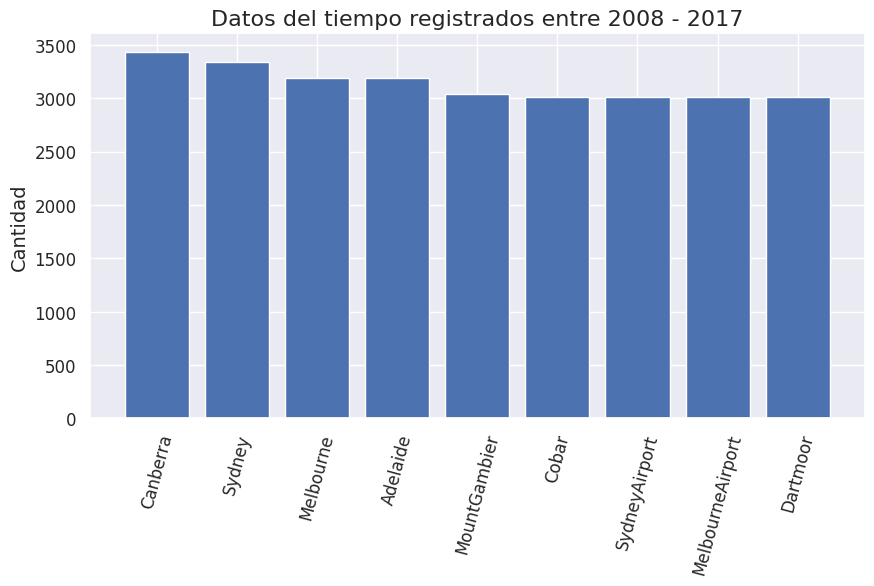

In [19]:
plt.figure(figsize=(10, 5))
plt.xticks(rotation=75, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Cantidad', fontsize=14)
plt.title('Datos del tiempo registrados entre 2008 - 2017',
          fontsize=16)
plt.bar(valores.index, valores)
plt.show()

El dataset esta desbalanceado por lo que aplicamos un truncamiento  utilizando como referencia la fecha de aparicion en el dataset de las ciudades con menores observaciones.

In [20]:
df= data.copy()

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28233 entries, 6047 to 102519
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        28233 non-null  int64  
 1   Date              28233 non-null  object 
 2   Location          28233 non-null  object 
 3   MinTemp           27663 non-null  float64
 4   MaxTemp           27675 non-null  float64
 5   Rainfall          27247 non-null  float64
 6   Evaporation       23880 non-null  float64
 7   Sunshine          21520 non-null  float64
 8   WindGustDir       26588 non-null  object 
 9   WindGustSpeed     26591 non-null  float64
 10  WindDir9am        26585 non-null  object 
 11  WindDir3pm        27796 non-null  object 
 12  WindSpeed9am      27875 non-null  float64
 13  WindSpeed3pm      27893 non-null  float64
 14  Humidity9am       27293 non-null  float64
 15  Humidity3pm       27343 non-null  float64
 16  Pressure9am       27394 non-null  float64

Las ciudades de Cobar, Sidney Airport, Melbourn Airport y Dartmoort tienen 3008 registros.
Tomamos como referencia Cobar para averiguar fecha que se comienzan a registrar mediciones para todas las ciudades

In [22]:
df["Date"][df["Location"] == "Cobar"]

6047    2009-01-01
6048    2009-01-02
6049    2009-01-03
6050    2009-01-04
6051    2009-01-05
           ...    
9050    2017-06-20
9051    2017-06-21
9052    2017-06-22
9053    2017-06-23
9054    2017-06-24
Name: Date, Length: 3008, dtype: object

In [23]:
df[df["Date"] == "2009-01-01"]

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
6047,6049,2009-01-01,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,...,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No,0.0
30502,30511,2009-01-01,Sydney,18.4,34.7,0.0,9.8,12.9,NaN,NaN,...,22.0,1005.5,1000.7,4.0,6.0,22.0,34.3,No,No,0.0
33510,33520,2009-01-01,SydneyAirport,17.7,35.1,0.0,9.8,12.9,S,72.0,...,13.0,1005.3,1000.2,6.0,6.0,22.9,34.0,No,No,0.0
46000,46014,2009-01-01,Canberra,12.6,27.1,0.0,10.6,13.3,W,65.0,...,24.0,1003.1,1001.1,1.0,1.0,19.7,26.2,No,No,0.0
64171,64191,2009-01-01,MelbourneAirport,11.2,19.9,0.0,5.6,8.8,SW,69.0,...,37.0,1005.1,1006.4,7.0,7.0,15.9,18.1,No,Yes,1.2
67363,67384,2009-01-01,Melbourne,14.7,20.4,0.0,5.6,8.8,SW,69.0,...,39.0,1005.4,1006.5,7.0,7.0,15.9,19.6,No,No,0.2
80972,80998,2009-01-01,Dartmoor,NaN,NaN,NaN,4.8,6.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96473,96504,2009-01-01,Adelaide,16.9,22.9,0.0,NaN,10.9,SW,50.0,...,40.0,1011.3,1012.4,NaN,NaN,18.1,22.5,No,No,0.0
99512,99544,2009-01-01,MountGambier,12.6,17.0,0.8,4.8,6.5,SW,56.0,...,43.0,1008.3,1011.6,7.0,5.0,14.3,16.6,No,No,0.0


Ordenamos el dataset y elegimos 2009-01-01 como fecha para truncamiento del dataset

In [24]:
df = df.sort_values(["Date"])
fecha_especifica = '2009-01-01'
df_filtrado = df[df['Date'] >= fecha_especifica]

df_filtrado.reset_index(drop = True, inplace = True)#Resetea el indice y no  crea uno  nuevo
df_filtrado

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,99544,2009-01-01,MountGambier,12.6,17.0,0.8,4.8,6.5,SW,56.0,...,43.0,1008.3,1011.6,7.0,5.0,14.3,16.6,No,No,0.0
1,96504,2009-01-01,Adelaide,16.9,22.9,0.0,NaN,10.9,SW,50.0,...,40.0,1011.3,1012.4,NaN,NaN,18.1,22.5,No,No,0.0
2,30511,2009-01-01,Sydney,18.4,34.7,0.0,9.8,12.9,NaN,NaN,...,22.0,1005.5,1000.7,4.0,6.0,22.0,34.3,No,No,0.0
3,80998,2009-01-01,Dartmoor,NaN,NaN,NaN,4.8,6.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,33520,2009-01-01,SydneyAirport,17.7,35.1,0.0,9.8,12.9,S,72.0,...,13.0,1005.3,1000.2,6.0,6.0,22.9,34.0,No,No,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27067,49021,2017-06-24,Canberra,0.1,14.4,0.0,NaN,NaN,NW,48.0,...,45.0,1017.5,1016.2,NaN,NaN,9.1,13.0,No,No,0.0
27068,84005,2017-06-24,Dartmoor,6.2,11.8,3.0,NaN,NaN,W,20.0,...,70.0,1019.8,1017.8,NaN,NaN,6.9,10.9,Yes,No,0.2
27069,9056,2017-06-24,Cobar,8.3,16.2,0.0,NaN,NaN,WSW,20.0,...,49.0,1020.2,1018.5,NaN,7.0,14.2,14.5,No,No,0.0
27070,99511,2017-06-24,Adelaide,5.0,17.3,0.0,NaN,NaN,W,17.0,...,54.0,1020.7,1018.5,NaN,NaN,9.6,16.7,No,No,0.0


In [25]:
df_filtrado['Location'].value_counts()

Location
MountGambier        3008
Adelaide            3008
Sydney              3008
Dartmoor            3008
SydneyAirport       3008
Cobar               3008
Melbourne           3008
Canberra            3008
MelbourneAirport    3008
Name: count, dtype: int64

In [26]:
df_filtrado = df_filtrado.drop('Unnamed: 0', axis =1)

Vamos a destinar el 80% de los datos a training y 20% a test

In [27]:
(len(df_filtrado) * 0.8)

21657.600000000002

In [28]:
len(df_filtrado) * 0.2

5414.400000000001

Decidimos para el train quedarnos con los primeros 21658 registros y  5414 para test

In [29]:
df_train  = df_filtrado.iloc[:21658]
df_train

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,2009-01-01,MountGambier,12.6,17.0,0.8,4.8,6.5,SW,56.0,SW,...,43.0,1008.3,1011.6,7.0,5.0,14.3,16.6,No,No,0.0
1,2009-01-01,Adelaide,16.9,22.9,0.0,NaN,10.9,SW,50.0,SW,...,40.0,1011.3,1012.4,NaN,NaN,18.1,22.5,No,No,0.0
2,2009-01-01,Sydney,18.4,34.7,0.0,9.8,12.9,NaN,NaN,W,...,22.0,1005.5,1000.7,4.0,6.0,22.0,34.3,No,No,0.0
3,2009-01-01,Dartmoor,NaN,NaN,NaN,4.8,6.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-01-01,SydneyAirport,17.7,35.1,0.0,9.8,12.9,S,72.0,NW,...,13.0,1005.3,1000.2,6.0,6.0,22.9,34.0,No,No,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21653,2015-10-31,Dartmoor,12.8,27.7,3.8,3.6,12.0,ENE,43.0,ENE,...,34.0,1011.4,1008.5,NaN,NaN,19.5,26.8,Yes,No,0.0
21654,2015-11-01,Canberra,8.9,25.3,2.2,NaN,NaN,W,57.0,NW,...,60.0,1015.7,1010.7,NaN,8.0,18.1,20.8,Yes,Yes,19.4
21655,2015-11-01,SydneyAirport,17.5,28.7,0.0,7.8,9.0,N,56.0,NNE,...,54.0,1015.0,1010.1,1.0,3.0,22.4,26.7,No,Yes,9.8
21656,2015-11-01,Dartmoor,9.9,17.8,0.0,6.6,1.8,W,30.0,NW,...,70.0,1010.1,1008.8,NaN,NaN,14.5,16.9,No,No,1.0


In [30]:
df_test = df_filtrado.iloc[21658:]
df_test

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
21658,2015-11-01,MelbourneAirport,15.0,27.0,4.8,7.0,5.2,N,72.0,N,...,59.0,1008.3,1006.7,4.0,7.0,21.2,21.0,Yes,No,0.2
21659,2015-11-01,Cobar,16.7,30.2,2.4,7.2,NaN,W,65.0,NE,...,45.0,1012.9,1008.3,6.0,6.0,21.6,28.2,Yes,Yes,7.6
21660,2015-11-01,MountGambier,12.0,18.3,0.0,6.6,1.8,WNW,37.0,WNW,...,77.0,1010.7,1009.0,8.0,7.0,14.9,15.3,No,Yes,2.6
21661,2015-11-01,Sydney,17.5,26.8,0.0,7.8,9.0,NE,44.0,E,...,59.0,1015.2,1010.6,1.0,3.0,21.9,25.4,No,Yes,26.0
21662,2015-11-01,Melbourne,NaN,NaN,NaN,7.0,5.2,N,72.0,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27067,2017-06-24,Canberra,0.1,14.4,0.0,NaN,NaN,NW,48.0,N,...,45.0,1017.5,1016.2,NaN,NaN,9.1,13.0,No,No,0.0
27068,2017-06-24,Dartmoor,6.2,11.8,3.0,NaN,NaN,W,20.0,NW,...,70.0,1019.8,1017.8,NaN,NaN,6.9,10.9,Yes,No,0.2
27069,2017-06-24,Cobar,8.3,16.2,0.0,NaN,NaN,WSW,20.0,W,...,49.0,1020.2,1018.5,NaN,7.0,14.2,14.5,No,No,0.0
27070,2017-06-24,Adelaide,5.0,17.3,0.0,NaN,NaN,W,17.0,NaN,...,54.0,1020.7,1018.5,NaN,NaN,9.6,16.7,No,No,0.0


### Funciones

In [31]:
def preprocesamiento(data):
    data.info()
    data.isna().sum()

    # Definir columnas con valores nulos
    columnas_con_nulos = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                          'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm','Humidity9am',
                          'Humidity3pm', 'Pressure9am','Pressure3pm', 'Cloud9am',
                          'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainfallTomorrow']

    # Rellenar valores faltantes en 'RainToday' y 'RainTomorrow'
    data['RainToday'] = data.groupby('Date')['RainToday'].transform(lambda x: x.fillna(x.mode().iloc[0]))
    data['RainTomorrow'] = data.groupby('Date')['RainTomorrow'].transform(lambda x: x.fillna(x.mode().iloc[0]))

    # Rellenar valores faltantes en direcciones del viento
    data['WindGustDir'] = data.groupby('Date')['WindGustDir'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.isna().all() else x)
    data['WindDir9am'] = data.groupby('Date')['WindDir9am'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.isna().all() else x)
    data['WindDir3pm'] = data.groupby('Date')['WindDir3pm'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.isna().all() else x)

    # Rellenar valores faltantes con la media por día para las columnas especificadas
    media_por_dia = data.groupby('Date')[columnas_con_nulos].transform('mean')
    data[columnas_con_nulos] = data[columnas_con_nulos].fillna(media_por_dia)

    data['Date'] = pd.to_datetime(data['Date'])

    return data



In [32]:
def asignar_estacion(fecha):
    mes = fecha.month
    if mes in [12, 1, 2]:  # Verano: Diciembre, Enero, Febrero
        return 'Summer'
    elif mes in [3, 4, 5]:  # Otoño: Marzo, Abril, Mayo
        return 'Autumn'
    elif mes in [6, 7, 8]:  # Invierno: Junio, Julio, Agosto
        return 'Winter'
    else:  # Primavera: Septiembre, Octubre, Noviembre
        return 'Spring'

In [33]:
def codificar_variables(data):

  data1 = data.copy()

  for var in ["SW", "S", 'SSW', 'W', 'SSE', 'E', 'SE', 'NE', 'NNE', 'WSW', 'WNW',
            'NW', 'N', 'ESE', 'ENE']:
    # Crear columnas para WindGustDir
    data1[f'WindGustDir_{var}'] = 0
    data1.loc[data['WindGustDir'] == var, f'WindGustDir_{var}'] = 1

    # Crear columnas para WindGust9am
    data1[f'WindDir9am_{var}'] = 0
    data1.loc[data['WindDir9am'] == var, f'WindDir9am_{var}'] = 1

    # Crear columnas para WindGust3pm
    data1[f'WindDir3pm_{var}'] = 0
    data1.loc[data['WindDir3pm'] == var, f'WindDir3pm_{var}'] = 1

    # Generamos dummys
    # Codificar la variable 'RainToday'
  data1 = pd.get_dummies(data1, columns=['RainToday'],drop_first=True)

    # Codificar la variable 'RainTomorrow'
  data1 = pd.get_dummies(data1, columns=['RainTomorrow'],drop_first=True)

    # Codificar la variable 'season'
  data1 = pd.get_dummies(data1, columns=['season'],drop_first=True)

    # Codificar la variable 'Location'
  data1 = pd.get_dummies(data1, columns=['Location'], drop_first=True)

  return data1

## Preprocesamiento

In [34]:
df_filtrado = preprocesamiento(df_filtrado)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27072 entries, 0 to 27071
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              27072 non-null  object 
 1   Location          27072 non-null  object 
 2   MinTemp           26503 non-null  float64
 3   MaxTemp           26515 non-null  float64
 4   Rainfall          26104 non-null  float64
 5   Evaporation       22782 non-null  float64
 6   Sunshine          20366 non-null  float64
 7   WindGustDir       25769 non-null  object 
 8   WindGustSpeed     25771 non-null  float64
 9   WindDir9am        25472 non-null  object 
 10  WindDir3pm        26640 non-null  object 
 11  WindSpeed9am      26725 non-null  float64
 12  WindSpeed3pm      26735 non-null  float64
 13  Humidity9am       26133 non-null  float64
 14  Humidity3pm       26183 non-null  float64
 15  Pressure9am       26235 non-null  float64
 16  Pressure3pm       26243 non-null  float6

Decidimos agregar una variable cualitativa 'season' cuyos valores posibles seran : Autumn, Spring, Winter,Summer mediante la funcion asignar_estacion a los dataset df_filtrado, df_train y df_test.


In [35]:
df_filtrado['season'] =  df_filtrado['Date'].apply(asignar_estacion)
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27072 entries, 0 to 27071
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              27072 non-null  datetime64[ns]
 1   Location          27072 non-null  object        
 2   MinTemp           27072 non-null  float64       
 3   MaxTemp           27072 non-null  float64       
 4   Rainfall          27072 non-null  float64       
 5   Evaporation       27072 non-null  float64       
 6   Sunshine          27072 non-null  float64       
 7   WindGustDir       27072 non-null  object        
 8   WindGustSpeed     27072 non-null  float64       
 9   WindDir9am        27072 non-null  object        
 10  WindDir3pm        27072 non-null  object        
 11  WindSpeed9am      27072 non-null  float64       
 12  WindSpeed3pm      27072 non-null  float64       
 13  Humidity9am       27072 non-null  float64       
 14  Humidity3pm       2707

In [36]:
df_train = preprocesamiento(df_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21658 entries, 0 to 21657
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              21658 non-null  object 
 1   Location          21658 non-null  object 
 2   MinTemp           21277 non-null  float64
 3   MaxTemp           21290 non-null  float64
 4   Rainfall          20908 non-null  float64
 5   Evaporation       19653 non-null  float64
 6   Sunshine          17626 non-null  float64
 7   WindGustDir       20427 non-null  object 
 8   WindGustSpeed     20429 non-null  float64
 9   WindDir9am        20284 non-null  object 
 10  WindDir3pm        21249 non-null  object 
 11  WindSpeed9am      21319 non-null  float64
 12  WindSpeed3pm      21325 non-null  float64
 13  Humidity9am       21029 non-null  float64
 14  Humidity3pm       21073 non-null  float64
 15  Pressure9am       21010 non-null  float64
 16  Pressure3pm       21015 non-null  float6

In [37]:
df_train['season'] = df_train['Date'].apply(asignar_estacion)

In [38]:
df_test = preprocesamiento(df_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5414 entries, 21658 to 27071
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              5414 non-null   object 
 1   Location          5414 non-null   object 
 2   MinTemp           5226 non-null   float64
 3   MaxTemp           5225 non-null   float64
 4   Rainfall          5196 non-null   float64
 5   Evaporation       3129 non-null   float64
 6   Sunshine          2740 non-null   float64
 7   WindGustDir       5342 non-null   object 
 8   WindGustSpeed     5342 non-null   float64
 9   WindDir9am        5188 non-null   object 
 10  WindDir3pm        5391 non-null   object 
 11  WindSpeed9am      5406 non-null   float64
 12  WindSpeed3pm      5410 non-null   float64
 13  Humidity9am       5104 non-null   float64
 14  Humidity3pm       5110 non-null   float64
 15  Pressure9am       5225 non-null   float64
 16  Pressure3pm       5228 non-null   flo

In [39]:
df_test['season'] = df_test['Date'].apply(asignar_estacion)

In [40]:
df_test

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow,season
21658,2015-11-01,MelbourneAirport,15.0,27.000,4.8,7.0,5.20,N,72.0,N,...,1008.300,1006.70,4.00,7.00,21.2,21.000,Yes,No,0.2,Spring
21659,2015-11-01,Cobar,16.7,30.200,2.4,7.2,5.30,W,65.0,NE,...,1012.900,1008.30,6.00,6.00,21.6,28.200,Yes,Yes,7.6,Spring
21660,2015-11-01,MountGambier,12.0,18.300,0.0,6.6,1.80,WNW,37.0,WNW,...,1010.700,1009.00,8.00,7.00,14.9,15.300,No,Yes,2.6,Spring
21661,2015-11-01,Sydney,17.5,26.800,0.0,7.8,9.00,NE,44.0,E,...,1015.200,1010.60,1.00,3.00,21.9,25.400,No,Yes,26.0,Spring
21662,2015-11-01,Melbourne,15.3,25.575,1.8,7.0,5.20,N,72.0,N,...,1011.775,1008.65,4.75,5.75,19.9,22.475,No,Yes,9.1,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27067,2017-06-24,Canberra,0.1,14.400,0.0,1.6,7.45,NW,48.0,N,...,1017.500,1016.20,3.80,5.50,9.1,13.000,No,No,0.0,Winter
27068,2017-06-24,Dartmoor,6.2,11.800,3.0,1.6,7.45,W,20.0,NW,...,1019.800,1017.80,3.80,5.50,6.9,10.900,Yes,No,0.2,Winter
27069,2017-06-24,Cobar,8.3,16.200,0.0,1.6,7.45,WSW,20.0,W,...,1020.200,1018.50,3.80,7.00,14.2,14.500,No,No,0.0,Winter
27070,2017-06-24,Adelaide,5.0,17.300,0.0,1.6,7.45,W,17.0,W,...,1020.700,1018.50,3.80,5.50,9.6,16.700,No,No,0.0,Winter


# Analisis exploratorio

Se utiliza para el analisis exploratorio df_filtrado

In [ ]:
print(df_filtrado.select_dtypes(include=['float64', 'int64']).describe())

            MinTemp       MaxTemp      Rainfall   Evaporation      Sunshine  \
count  27072.000000  27072.000000  27072.000000  27072.000000  27072.000000   
mean      11.328903     21.987982      2.046205      4.862742      6.844573   
std        5.705777      6.728221      6.302651      3.622090      3.615105   
min       -8.000000      4.100000      0.000000      0.000000      0.000000   
25%        7.400000     16.600000      0.000000      2.200000      4.166667   
50%       11.000000     21.100000      0.000000      4.000000      7.100000   
75%       15.200000     26.300000      1.000000      6.600000      9.700000   
max       33.900000     46.800000    119.400000     86.200000     14.300000   

       WindGustSpeed  WindSpeed9am  WindSpeed3pm   Humidity9am   Humidity3pm  \
count   27072.000000  27072.000000  27072.000000  27072.000000  27072.000000   
mean       41.874885     15.193268     20.068882     68.794094     50.561941   
std        14.050626      9.429529      8.954737

In [ ]:
df_filtrado_numerico = df_filtrado.select_dtypes(include=['float64', 'int64'])

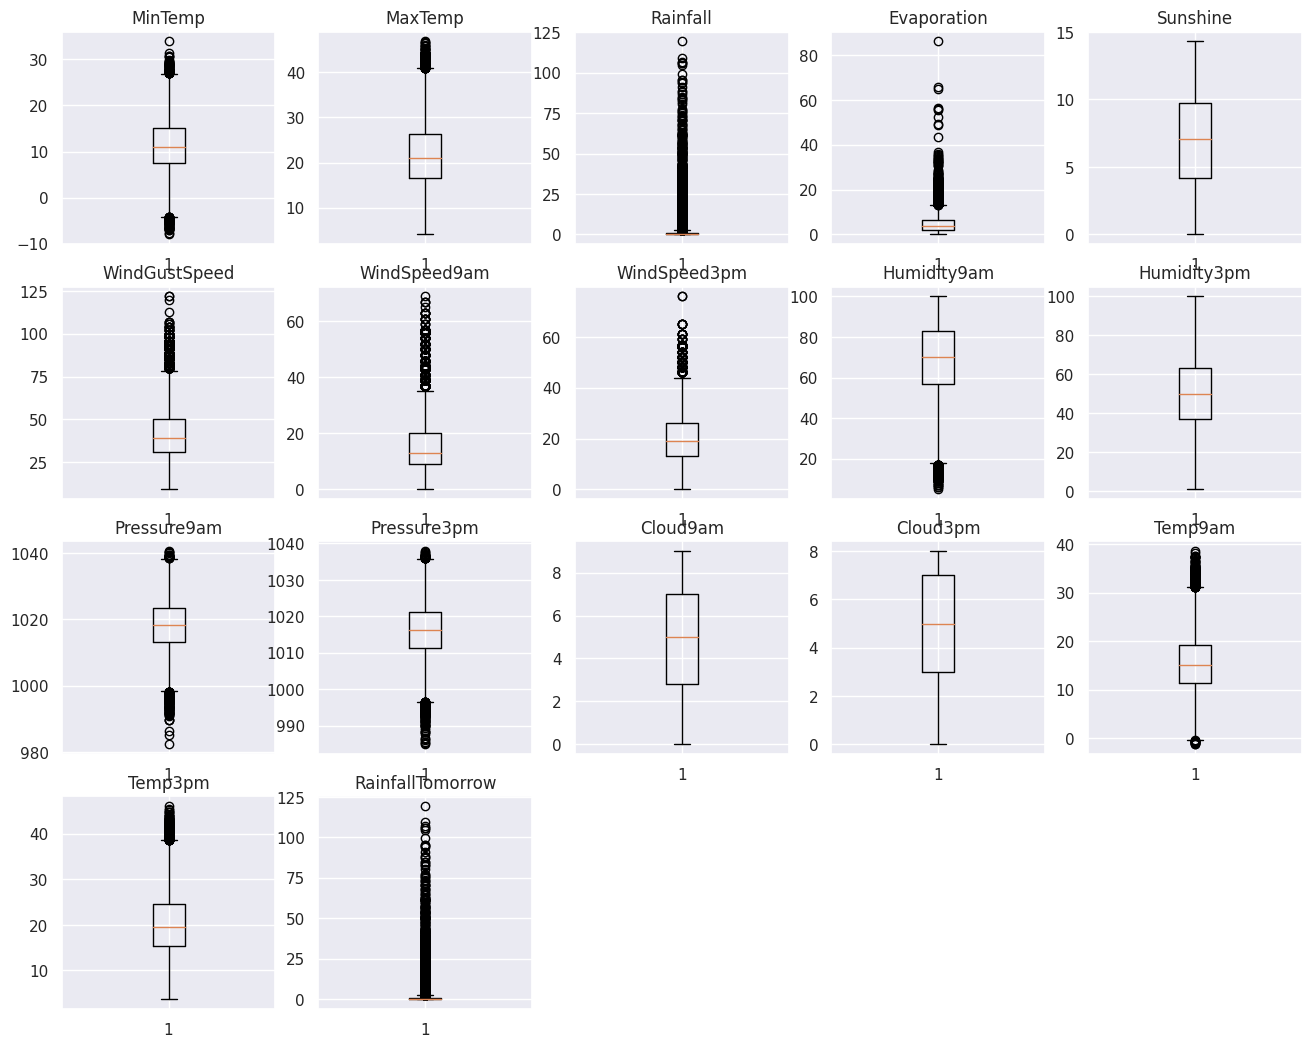

In [ ]:
plt.figure(figsize=(16, 16))

for idx, col in enumerate(df_filtrado_numerico.columns[0:17], start=1):
    plt.subplot(5, 5, idx)
    plt.boxplot(df_filtrado[col])
    plt.title(col)

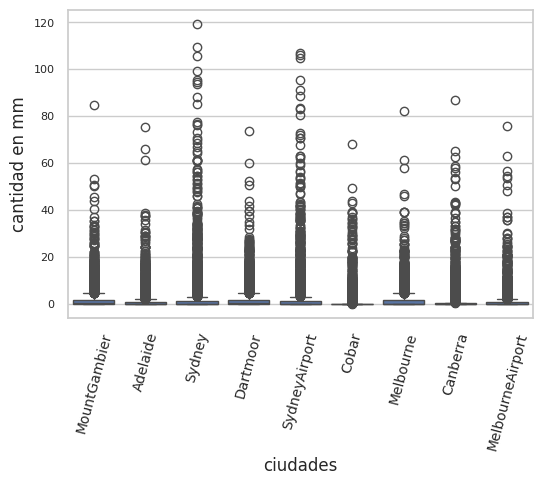

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
plt.xticks(rotation=75, fontsize=10)
plt.yticks(fontsize=8)
sns.boxplot(x='Location', y='Rainfall', data=df_filtrado)
plt.title('')
plt.xlabel('ciudades')
plt.ylabel('cantidad en mm')
plt.show()

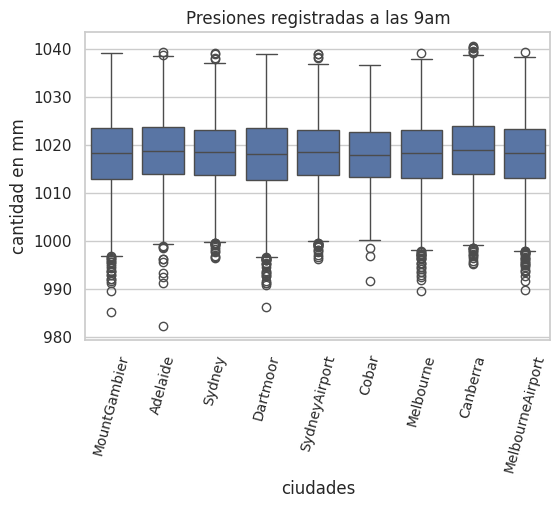

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
plt.xticks(rotation=75, fontsize=10)
sns.boxplot(x='Location', y='Pressure9am', data=df_filtrado)
plt.title('Presiones registradas a las 9am')
plt.xlabel('ciudades')
plt.ylabel('cantidad en mm')
plt.show()

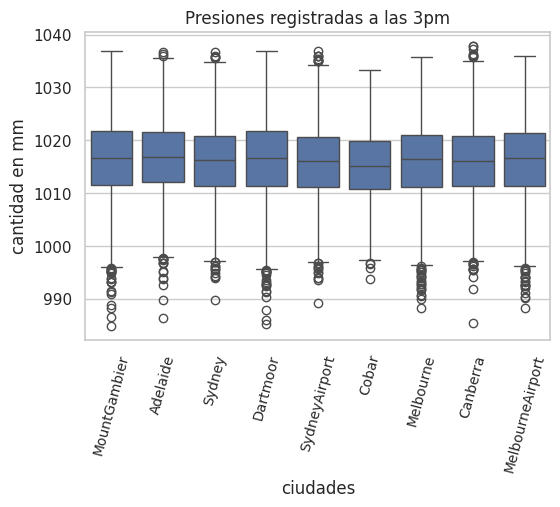

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
plt.xticks(rotation=75, fontsize=10)
sns.boxplot(x='Location', y='Pressure3pm', data=df_filtrado)
plt.title('Presiones registradas a las 3pm')
plt.xlabel('ciudades')
plt.ylabel('cantidad en mm')
plt.show()

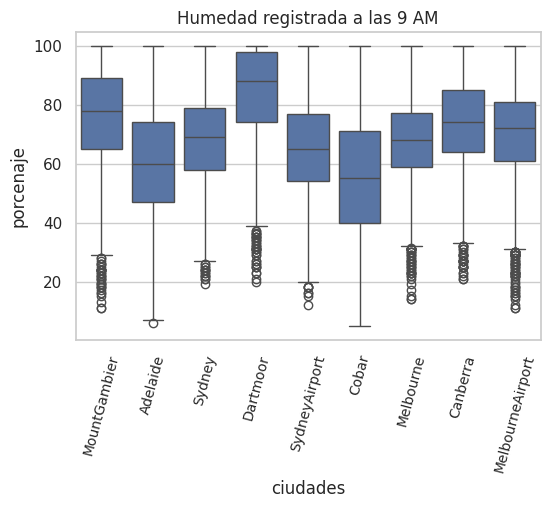

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
plt.xticks(rotation=75, fontsize=10)
sns.boxplot(x='Location', y= 'Humidity9am', data=df_filtrado)
plt.title('Humedad registrada a las 9 AM' )
plt.xlabel('ciudades')
plt.ylabel('porcenaje')
plt.show()

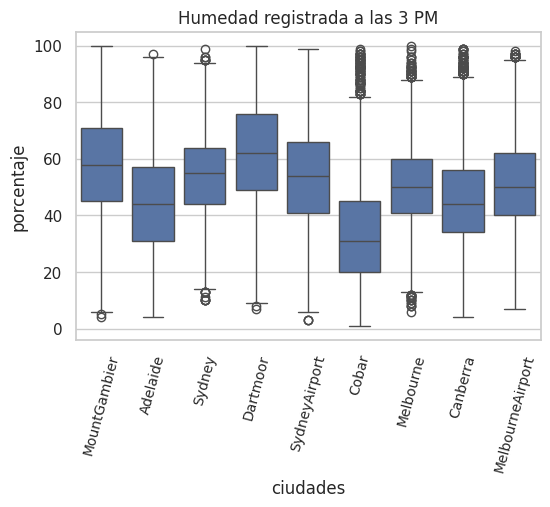

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
plt.xticks(rotation=75, fontsize=10)
sns.boxplot(x='Location', y='Humidity3pm', data=df_filtrado)
plt.title('Humedad registrada a las 3 PM')
plt.xlabel('ciudades')
plt.ylabel('porcentaje')
plt.show()

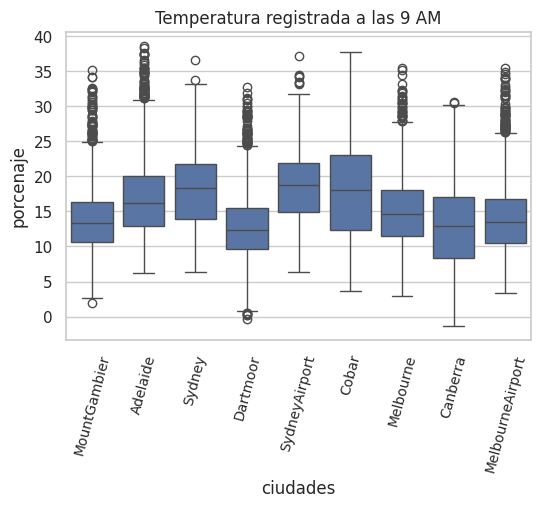

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
plt.xticks(rotation=75, fontsize=10)
sns.boxplot(x='Location', y= 'Temp9am', data=df_filtrado)
plt.title('Temperatura registrada a las 9 AM' )
plt.xlabel('ciudades')
plt.ylabel('porcenaje')
plt.show()

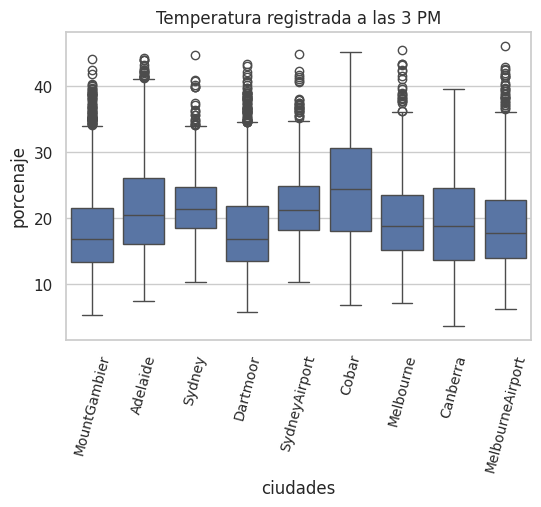

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
plt.xticks(rotation=75, fontsize=10)
sns.boxplot(x='Location', y= 'Temp3pm', data=df_filtrado)
plt.title('Temperatura registrada a las 3 PM' )
plt.xlabel('ciudades')
plt.ylabel('porcenaje')
plt.show()

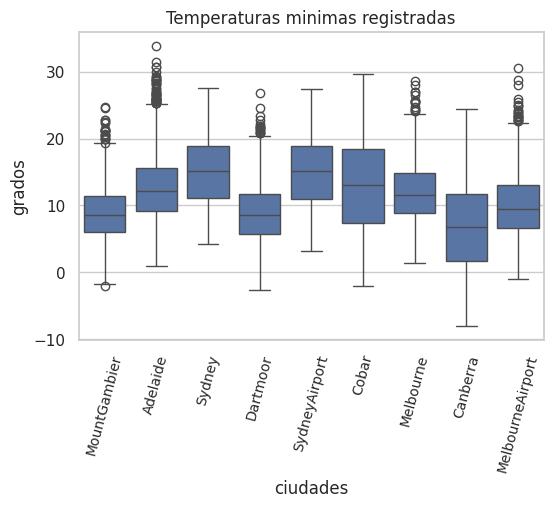

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
plt.xticks(rotation=75, fontsize=10)
sns.boxplot(x='Location', y= 'MinTemp', data=df_filtrado)
plt.title('Temperaturas minimas registradas')
plt.xlabel('ciudades')
plt.ylabel('grados')
plt.show()

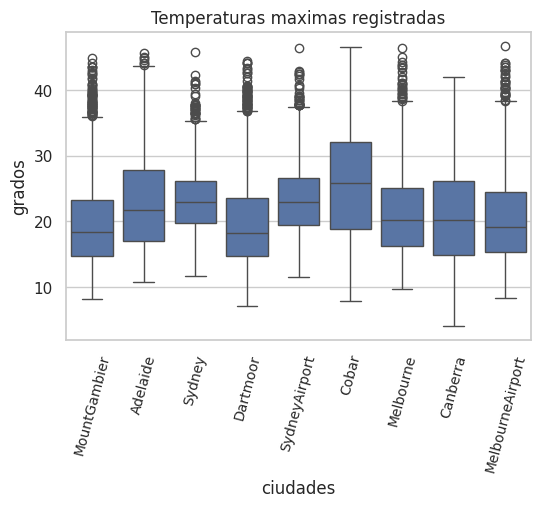

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
plt.xticks(rotation=75, fontsize=10)
sns.boxplot(x='Location', y= 'MaxTemp', data=df_filtrado)
plt.title('Temperaturas maximas registradas')
plt.xlabel('ciudades')
plt.ylabel('grados')
plt.show()

Decidimos mantener los outliers ya que consideramos que pueden ser casos atipicos puesto que al disciminarlos por ciudad estan presentes en la mayoria.

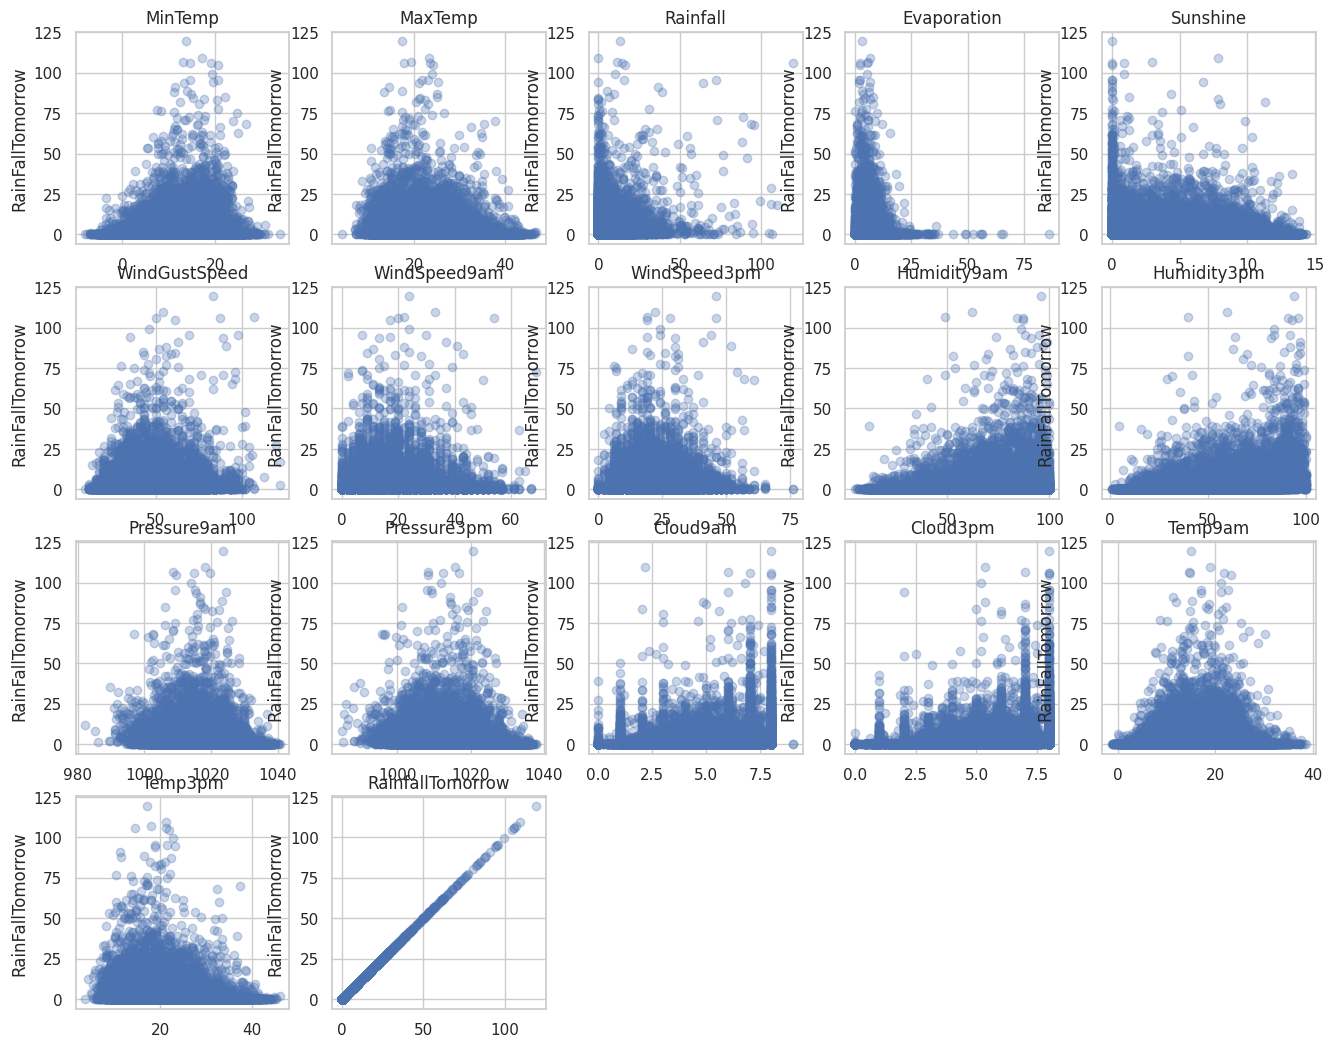

In [ ]:
plt.figure(figsize=(16, 16))

for idx, col in enumerate(df_filtrado_numerico.columns[0:17], start=1):
    plt.subplot(5, 5, idx)
    plt.ylabel('RainFallTomorrow')
    plt.scatter(data=df_filtrado, x=col, y='RainfallTomorrow', alpha=.3)
    plt.title(col)

Evaluamos el comportamiento de la variable RainFallTomorrow respecto del resto de las variables cuantitativas, no observamos una correlacion lineal fuerte con ninguna de ellas.  

In [ ]:
df_yes_today = df_filtrado[df_filtrado['RainToday'] == 'Yes']
df_no_today = df_filtrado[df_filtrado['RainToday'] == 'No']
df_yes_tomorrow = df_filtrado[df_filtrado['RainTomorrow'] == 'Yes']
df_no_tomorrow = df_filtrado[df_filtrado['RainTomorrow'] == 'No']

In [ ]:
rain_today_season = df_yes_today.groupby("season")["RainToday"].count()
no_rain_today_season = df_no_today.groupby("season")["RainToday"].count()
rain_tomorrow_season = df_yes_tomorrow.groupby("season")["RainTomorrow"].count()
no_rain_tomorrow_season = df_no_tomorrow.groupby("season")["RainTomorrow"].count()

In [ ]:
rain_today_percent = (rain_today_season /(rain_today_season + no_rain_today_season))*100
no_rain_today_percent = (no_rain_today_season /(rain_today_season + no_rain_today_season))*100
rain_tomorrow_percent = (rain_tomorrow_season /(rain_tomorrow_season + no_rain_tomorrow_season))*100
no_rain_tomorrow_percent = (no_rain_tomorrow_season /(rain_tomorrow_season + no_rain_tomorrow_season))*100

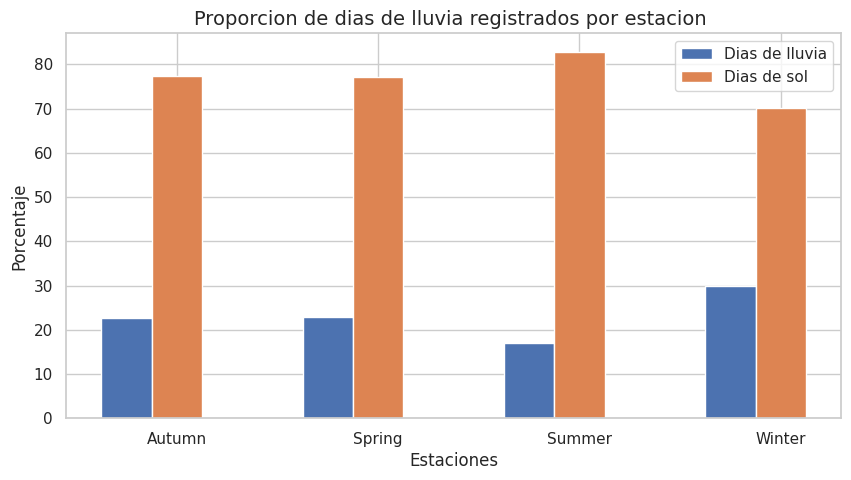

In [ ]:
x = np.arange(4)
plt.figure(figsize = (10,5))
plt.title("Proporcion de dias de lluvia registrados por estacion ",fontsize=14)
plt.xlabel("Estaciones", fontsize=12)
plt.ylabel("Porcentaje",fontsize=12)
plt.bar(x -0.25, rain_today_percent, width=0.25,label = 'Dias de lluvia')
plt.bar(x , no_rain_today_percent,width=0.25, label = 'Dias de sol')
plt.xticks(x,rain_today_season.index)
plt.legend()
plt.show()

In [ ]:
rain_today_percent.round(2)

season
Autumn    22.74
Spring    22.91
Summer    17.11
Winter    29.96
Name: RainToday, dtype: float64

In [ ]:
dias_por_estacion = 90*(rain_today_percent.round(2)/100)
dias_por_estacion

season
Autumn    20.466
Spring    20.619
Summer    15.399
Winter    26.964
Name: RainToday, dtype: float64

En el grafico de barras podemos observar que el invierno tiene el mayor porcentaje de días de precipitaciones, alrededor del 30%, mientras que el verano tiene el porcentaje mas bajo, alrededor del 17%. Las estaciones de otoño y primavera presentan alrededor de un 23% . Esto significa que el invierno registra alrededor de 27 dias de lluvia en un total de 90 dias.Otoño alrededor de 20 dias, primavera, 21 dias y verano registraria aproximadamente 15 dias de lluvia.

In [ ]:
print('Otono     ',rain_tomorrow_percent.values[0].round(2),no_rain_tomorrow_percent.values[0].round(2))
print('Primavera ', rain_tomorrow_percent.values[1].round(2),no_rain_tomorrow_percent.values[1].round(2))
print('Verano    ', rain_tomorrow_percent.values[2].round(2), no_rain_tomorrow_percent.values[2].round(2))
print('Invierno  ', rain_tomorrow_percent.values[3].round(2), no_rain_tomorrow_percent.values[3].round(2))

Otono      22.7 77.3
Primavera  22.97 77.03
Verano     17.28 82.72
Invierno   29.78 70.22


Podemos concluir que el dataset esta desbalanceado para la variable RainTomorrow por lo que deberemos aplicar alguna tecnica de balanceo para el modelo de clasificacion

## Matriz de correlacion

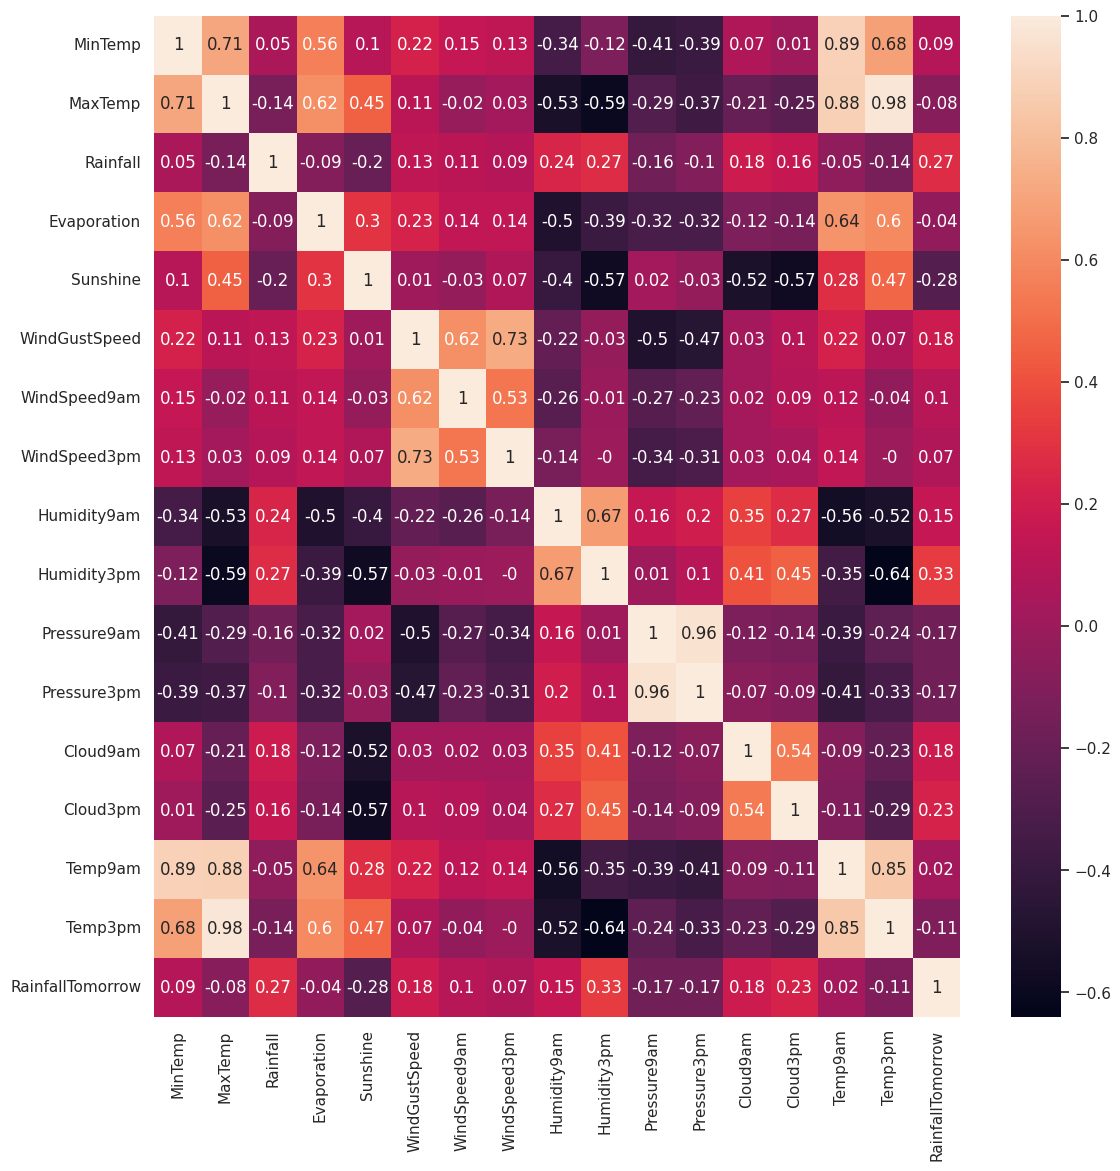

In [ ]:
corr = df_filtrado.drop('WindGustDir', axis=1)\
           .drop('Date', axis = 1)\
           .drop('Location', axis = 1)\
           .drop('WindDir9am', axis = 1)\
           .drop('WindDir3pm', axis = 1)\
           .drop('RainToday', axis = 1)\
           .drop('RainTomorrow', axis = 1)\
           .drop('season', axis = 1)\
           .corr().round(2)

plt.figure(figsize = (13,13   ))
sns.heatmap(corr, annot=True)
plt.show()

Las variables con mayor correlacion lineal positiva;

*   MaxTemp - Temp3pm (0.98)
*   Pressure - Pressure3pm (0.96)
*   MinTemp - Temp9am (0.89)
*   MaxTemp - Temp9pm (0.88)
*   WindGustSpeed - WindSpeed3pm (0.73)
*   Evaporation - Temp9pm (0.64)

Las variables con mayor correlacion lineal negativa son:

*   Humidity3pm - Temp3pm (-0.64)
*   MaxTemp - Humidity3pm (-0.59)
*   Sunshine - Humidity3pm (-0.57)   
*   Sunshine - Cloud3pm (-0.57)  


## Codificacion de variables categoricas

In [41]:
df_train['WindGustDir'].unique()

array(['SW', 'S', 'SSW', 'W', 'SSE', 'E', 'SE', 'NE', 'NNE', 'WSW', 'WNW',
       'NW', 'N', 'ESE', 'ENE', 'NNW'], dtype=object)

In [42]:
df_train_codificado = codificar_variables(df_train)

In [43]:
df_train_codificado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21658 entries, 0 to 21657
Data columns (total 79 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       21658 non-null  datetime64[ns]
 1   MinTemp                    21658 non-null  float64       
 2   MaxTemp                    21658 non-null  float64       
 3   Rainfall                   21658 non-null  float64       
 4   Evaporation                21658 non-null  float64       
 5   Sunshine                   21658 non-null  float64       
 6   WindGustDir                21658 non-null  object        
 7   WindGustSpeed              21658 non-null  float64       
 8   WindDir9am                 21658 non-null  object        
 9   WindDir3pm                 21658 non-null  object        
 10  WindSpeed9am               21658 non-null  float64       
 11  WindSpeed3pm               21658 non-null  float64       
 12  Humi

In [44]:
df_test_codificado = codificar_variables(df_test)

In [45]:
df_test_codificado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5414 entries, 21658 to 27071
Data columns (total 79 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       5414 non-null   datetime64[ns]
 1   MinTemp                    5414 non-null   float64       
 2   MaxTemp                    5414 non-null   float64       
 3   Rainfall                   5414 non-null   float64       
 4   Evaporation                5414 non-null   float64       
 5   Sunshine                   5414 non-null   float64       
 6   WindGustDir                5414 non-null   object        
 7   WindGustSpeed              5414 non-null   float64       
 8   WindDir9am                 5414 non-null   object        
 9   WindDir3pm                 5414 non-null   object        
 10  WindSpeed9am               5414 non-null   float64       
 11  WindSpeed3pm               5414 non-null   float64       
 12  H

In [46]:
df_train_codificado = df_train_codificado.drop(columns= ['Date', 'WindGustDir', 'WindDir9am', 'WindDir3pm'])

In [47]:
df_test_codificado = df_test_codificado.drop(columns= ['Date', 'WindGustDir', 'WindDir9am', 'WindDir3pm'])

**VALIDACION TRAIN-TEST**

In [48]:
# Dividir el conjunto de datos de entrenamiento en características (X) y variables objetivo (y)
X_train_regresion = df_train_codificado.drop(columns=['RainfallTomorrow'])
X_train_clasificacion = df_train_codificado.drop(columns=['RainTomorrow_Yes', "RainfallTomorrow"])

y_train_rainfall_tomorrow = df_train_codificado['RainfallTomorrow']
y_train_rain_tomorrow = df_train_codificado['RainTomorrow_Yes']

In [49]:
# Dividir el conjunto de datos de test en características (X) y variables objetivo (y)
X_test_regresion = df_test_codificado.drop(columns=['RainfallTomorrow'])
X_test_clasificacion = df_test_codificado.drop(columns=['RainTomorrow_Yes', "RainfallTomorrow"])

y_test_rain_tomorrow = df_test_codificado['RainTomorrow_Yes']
y_test_rainfall_tomorrow = df_test_codificado['RainfallTomorrow']

## Estandarizacion

In [50]:
#Utilizamos RobustScaler porque es menos sensible a los valores atipicos.
scaler = RobustScaler()

In [51]:
X_train_scaled=scaler.fit_transform(X_train_regresion)
X_test_scaled=scaler.transform(X_test_regresion)

y_train_scaled = scaler.fit_transform(y_train_rainfall_tomorrow.values.reshape(-1,1))
y_test_scaled = scaler.fit_transform(y_test_rainfall_tomorrow.values.reshape(-1,1))

In [52]:
X_train_scaled1=scaler.fit_transform(X_train_clasificacion)
X_test_scaled1=scaler.transform(X_test_clasificacion)

y_train_scaled1 = scaler.fit_transform(y_train_rain_tomorrow.values.reshape(-1,1))
y_test_scaled1 = scaler.fit_transform(y_test_rain_tomorrow.values.reshape(-1,1))

In [53]:
X_train_scaled

array([[ 0.24675325, -0.4       ,  0.8       , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.80519481,  0.22105263,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  1.46315789,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.88311688,  0.83157895,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [-0.1038961 , -0.31578947,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.62337662,  0.46315789,  0.4       , ...,  0.        ,
         0.        ,  0.        ]])

In [54]:
X_train_scaled1

array([[ 0.24675325, -0.4       ,  0.8       , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.80519481,  0.22105263,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  1.46315789,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.88311688,  0.83157895,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [-0.1038961 , -0.31578947,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.62337662,  0.46315789,  0.4       , ...,  0.        ,
         0.        ,  0.        ]])

## Regresion Lineal

In [55]:
def metricas(y_test, y_pred):
    print('R2:   %.2f' % r2_score(y_test, y_pred))
    print('MSE:  %.2f' % mean_squared_error(y_test, y_pred))
    print('MAE:  %.2f' % mean_absolute_error(y_test, y_pred))

In [56]:
def gradient_descent(X_train, y_train, X_test, y_test, lr, epochs):

    n = X_train.shape[0]
    m = X_train.shape[1]

    o = X_test.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((o, 1)), X_test))


    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for i in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W)
        error_train = y_train - prediction_train
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_test, W)
        error_test = y_test - prediction_test
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de test')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y prueba vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return

In [57]:
def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr, epochs):

    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        for j in range(n):
            # Obtener una muestra aleatoria de un solo dato para hacer SGD
            x_sample = X_train[j]
            y_sample = y_train[j][0]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            train_mse = error ** 2
            train_errors.append(train_mse)

            gradient = -2 * error * x_sample.T.reshape(-1, 1)

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
    plt.show()

    return

In [58]:
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr, epochs, batch_size=1000):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):

        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]


        for j in range(0, n, batch_size):
            # Obtener un lote (mini-batch) de datos
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return

In [59]:
regresion = LinearRegression()
regresion.fit(X_train_scaled,y_train_scaled)

LinearRegression()

In [60]:
y_pred_regresion = regresion.predict(X_test_scaled)

metricas(y_test_scaled, y_pred_regresion)

R2:   0.38
MSE:  28.11
MAE:  2.26


 R2 nos da 0.38, es decir que solo pueden llegar a explicar un 38% de la variabilidad de los datos.

 MSE es similar a la medida estadística de varianza que nos permite medir la incertidumbre alrededor de nuestro más probable pronóstico.En nuestro caso es de 28.10, por lo tanto la incertidumbre en el resultado es de 28,1 mm.

 El error absoluto medio(MAE) es una medida común del error de pronóstico en análisis de series de tiempo, nos da 2,26.



In [61]:
print(regresion.coef_)

[[-4.13947587e-01  9.26037297e-01  1.23827456e-01 -4.66271982e-02
  -5.81917335e-01  8.48415808e-01  1.04610844e-01 -3.90574624e-01
  -2.19374017e-01  1.56529101e+00  2.65316031e+00 -2.75709404e+00
  -1.36715081e-01  4.06939798e-02  6.95076154e-02 -1.17385840e-01
  -7.13673052e-02  2.23820440e-01  2.93406258e-01  3.03985836e-01
   5.57354299e-01 -1.98001609e-03  6.59494022e-02  5.04086376e-01
   3.11566961e-01 -2.49520931e-01  3.06071978e-01  2.51532775e-01
   6.72323911e-01  8.02688036e-01  1.14601094e-02  9.13595698e-01
   1.03867893e+00 -7.25363939e-01  8.85441305e-01  6.37662234e-01
  -7.70149582e-02 -3.47919242e-03  6.09115054e-01 -5.49109507e-01
  -1.27231753e-01  4.15692537e-01 -1.20574700e-01  1.37912866e-01
   4.02945054e-01  5.56637584e-02 -1.19674220e-01  4.88390427e-02
  -3.89125525e-02  7.98777402e-02 -1.88656420e-02 -2.39853228e-01
   1.04262903e-01  1.11309579e-01 -2.31531601e-01  6.28653825e-01
   9.36197110e-01 -1.42016346e-01  1.66583565e-01  6.22395336e-01
  -2.32278

## Gradiente Descendiente

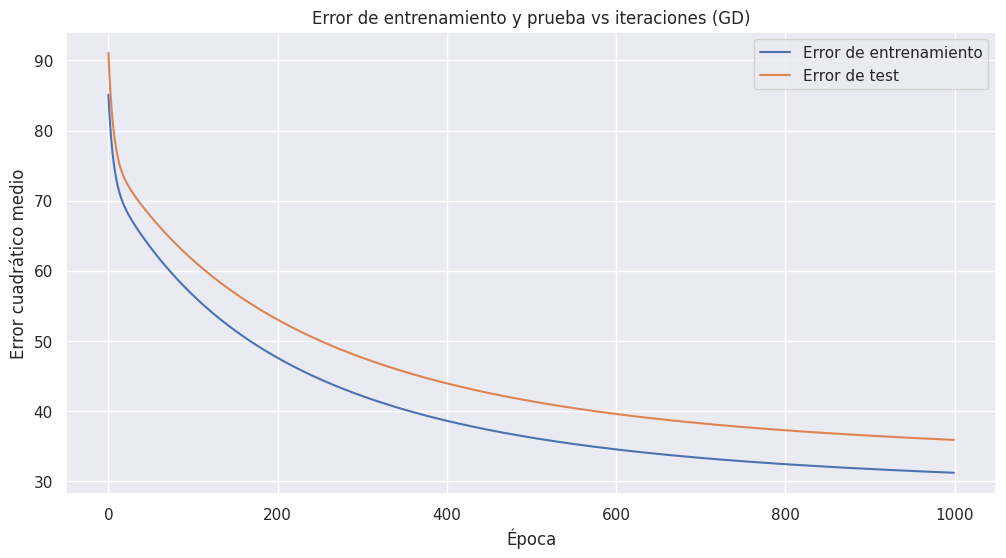

In [62]:
gradient_descent(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, lr=0.001, epochs=1000)

Con este algoritmo de optimizacion el MSE de test coincide con el MSE de la Regresion lineal para la prediccion.Necesita 1000 iteraciones para encontrarlo, con un lr de 0.001

### Gradiente Descendiente Estocastico

In [63]:
gradiente = SGDRegressor()
gradiente.fit(X_train_scaled, y_train_scaled)

SGDRegressor()

In [64]:
y_pred_gradiente = gradiente.predict(X_test_scaled)

metricas(y_test_scaled, y_pred_gradiente)

R2:   0.35
MSE:  29.36
MAE:  2.58


In [ ]:
stochastic_gradient_descent(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, lr=0.1, epochs=50)

### Gradiente Descendiente (Mini_batch)

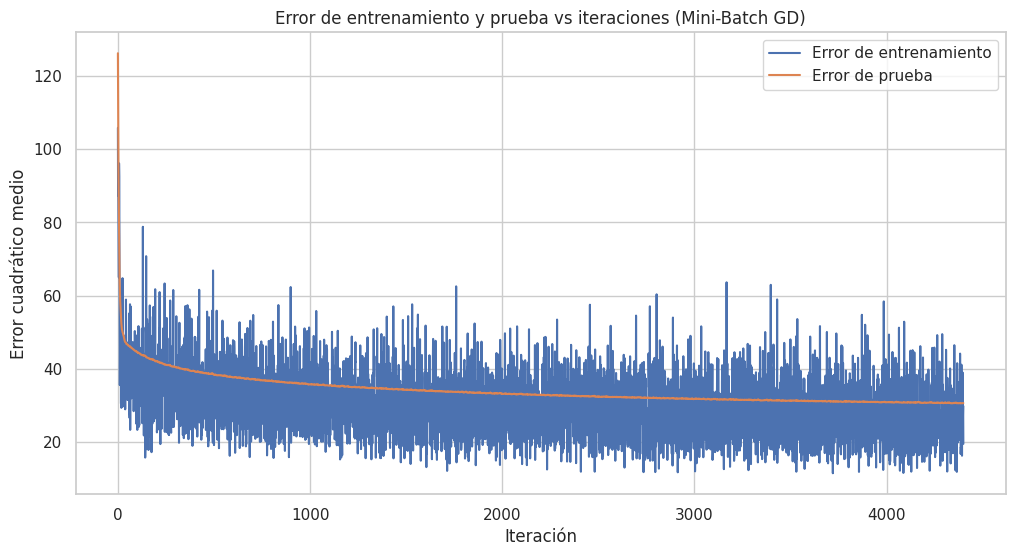

In [ ]:
mini_batch_gradient_descent(X_train_scaled, y_train_scaled,\
                            X_test_scaled, y_test_scaled,lr=0.001,\
                            epochs=200)


Con Gradiente descendiente(mini_batch) en 200 epocas, el error de test llega a su nivel mas bajo con lr = 0.001.

## Metodos de regularizacion

## Ridge

In [65]:
ridge = RidgeCV()
ridge.fit(X_train_scaled, y_train_scaled)

RidgeCV()

In [66]:
y_pred_ridge = ridge.predict(X_test_scaled)

metricas(y_test_scaled, y_pred_ridge)

R2:   0.38
MSE:  28.12
MAE:  2.26


In [67]:
print("\nCoeficientes del modelo Ridge:")
print(ridge.coef_)


Coeficientes del modelo Ridge:
[[-4.16054678e-01  8.83583670e-01  1.23862135e-01 -4.80315127e-02
  -5.85345182e-01  8.49516679e-01  1.00997210e-01 -3.91456642e-01
  -2.24137076e-01  1.56867662e+00  2.54230062e+00 -2.65107028e+00
  -1.34980874e-01  4.26306400e-02  5.47796577e-02 -5.58578739e-02
  -1.08759665e-01  1.65056415e-01  2.98866445e-01  2.64102270e-01
   4.97837523e-01  1.61803538e-02  2.85405953e-02  4.44748288e-01
   3.22499240e-01 -2.82830239e-01  2.52647805e-01  2.53012668e-01
   6.28795001e-01  7.42791047e-01  3.32578571e-02  8.64383021e-01
   9.76148099e-01 -6.85074210e-01  8.36077698e-01  5.81908715e-01
  -4.97065071e-02 -3.98945167e-02  5.51608357e-01 -5.11664327e-01
  -1.57020410e-01  3.65076418e-01 -8.90118338e-02  1.00203902e-01
   3.43046909e-01  6.10471270e-02 -1.52148418e-01 -1.72245425e-03
  -3.55623651e-02  4.92315146e-02 -6.57928957e-02 -2.31331297e-01
   7.37495623e-02  6.47436125e-02 -2.07488279e-01  5.84492450e-01
   8.73529667e-01 -1.09549652e-01  1.2730868

In [68]:
print("Ridge_Score df_train:", ridge.score(X_train_scaled, y_train_scaled))
print("Ridge_Score df_test:", ridge.score(X_test_scaled, y_test_scaled))

Ridge_Score df_train: 0.3526362542562971
Ridge_Score df_test: 0.37725423557537685


## Lasso

In [69]:
lasso = LassoCV()
lasso.fit(X_train_scaled, y_train_scaled)

LassoCV()

In [70]:
y_pred_lasso = lasso.predict(X_test_scaled)

metricas(y_test_scaled, y_pred_lasso)

R2:   0.37
MSE:  28.28
MAE:  2.17


In [71]:
print("\nCoeficientes del modelo Lasso:")
print(lasso.coef_)



Coeficientes del modelo Lasso:
[-0.17392292  0.70895444  0.12574304 -0.         -0.54666383  0.7411769
  0.05389639 -0.35404183 -0.19485125  1.39702549  1.8590847  -1.92872063
 -0.04968545  0.          0.          0.         -0.03633033 -0.04068805
  0.          0.14442686  0.0309278   0.          0.          0.
  0.10982026 -0.22414412 -0.          0.          0.43753578  0.25368369
  0.          0.51411202  0.39270618 -0.20516611  0.55651086  0.0893408
  0.         -0.          0.         -0.0938238  -0.00737079 -0.
  0.          0.         -0.         -0.         -0.07360717 -0.1574191
 -0.         -0.         -0.20664753 -0.05804993 -0.         -0.2148151
 -0.          0.30508436  0.31151633  0.          0.          0.
  0.         -0.26571792  6.38310044 -0.0402955   0.08281126 -0.12601501
  0.1580493   0.15577499 -0.61703194 -0.         -0.39864074 -0.47786557
  0.48466809  0.22381947]


In [72]:
print("Lasso_Score df_train:", lasso.score(X_train_scaled, y_train_scaled))
print("Lasso_Score df_test:", lasso.score(X_test_scaled, y_test_scaled))

Lasso_Score df_train: 0.3499923162254387
Lasso_Score df_test: 0.3736905024111441


### ElasticNet

In [73]:
elastic = ElasticNetCV()
elastic.fit(X_train_scaled, y_train_scaled)

ElasticNetCV()

In [74]:
y_pred_elastic = elastic.predict(X_test_scaled)

metricas(y_test_scaled, y_pred_elastic)

R2:   0.37
MSE:  28.51
MAE:  2.15


In [75]:
print("\nCoeficientes del modelo ElasticNet:")
print(elastic.coef_)


Coeficientes del modelo ElasticNet:
[-1.56289814e-01  5.66913167e-01  1.27338813e-01 -7.45397282e-03
 -5.96315100e-01  7.43407750e-01  2.90491786e-02 -3.55634565e-01
 -1.75148092e-01  1.37776246e+00  1.10896452e+00 -1.23974718e+00
 -4.88881609e-02  2.45098087e-02  0.00000000e+00  1.61824320e-01
 -1.19393506e-01 -9.38207965e-02  0.00000000e+00  5.47121786e-02
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  4.53367325e-02 -2.59527340e-01 -0.00000000e+00  0.00000000e+00
  3.20304287e-01  2.17479761e-01  0.00000000e+00  3.87661940e-01
  3.50170835e-01 -1.10404383e-01  4.00735714e-01  1.14655326e-01
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -2.63413456e-03
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -5.63534713e-02 -9.15642853e-02 -1.61094113e-01
 -2.09689365e-02 -0.00000000e+00 -1.91685784e-01 -3.56431742e-02
 -0.00000000e+00 -1.65461059e-01 -0.00000000e+00  2.24233188e-01
  2.70481338e-01  0.00000000e+00  0.00000000e+00  0.0

In [76]:
print("ElasticNet_Score df_train:", elastic.score(X_train_scaled, y_train_scaled))
print("ElasticNet_Score df_test:", elastic.score(X_test_scaled, y_test_scaled))

ElasticNet_Score df_train: 0.34731944998343045
ElasticNet_Score df_test: 0.3685113831435083


De los cuatro modelos lineales que probamos vemos que la regresion lineal y Ridge nos dan un R2 de aproximadamente 0.38, es decir que solo pueden llegar a explicar un 38% de la variabilidad de los datos.

En todos los casos el score de test nos da levemente mejor que el de train,podemos asegurar que no esta sobrejustado.

## Modelo de clasificacion

### Regresion logistica

In [77]:
# Se define el modelo de Regresión Logística, se entrena el modelo y se prueba
#random_state produce el mismo resultado en diferentes llamadas
#class_weight = 'balanced' ajusta los pesos inversamente proporcional a la frecuencia de la clase
logreg = LogisticRegression(random_state=42,class_weight='balanced')


Modelo de entrenamiento

In [78]:
logreg.fit(X_train_scaled1, y_train_scaled1)

LogisticRegression(class_weight='balanced', random_state=42)

In [79]:
# Hacer predicciones en el conjunto de entrenamiento
y_pred_train = logreg.predict(X_train_scaled1)

### Metricas para evaluar modelos de clasificacion:

**Perdida logaritmica:**

Es una metrica de clasificacion basada en probabilidades.A medida que la probabilidad de la clase verdadera se acerca a cero, la perdida aumenta exponencialmente..

Mide el desempeño de un modelo de clasificacion en el que la entrada de la prediccion es un valor de probabilidad entre 0 y 1.La perdida logaritmica aumente a medida que la probabilidad predicha se aleja de la etiqueta real

**Precision:**

La métrica de precisión es utilizada para poder saber qué porcentaje de valores que se han clasificado como positivos son realmente positivos.

**Recall:**

La métrica de recall, también conocida como el ratio de verdaderos positivos, es utilizada para saber cuantos valores positivos son correctamente clasificados.

**f1_score:**

Esta es una métrica muy utilizada en problemas en los que el conjunto de datos a analizar está desbalanceado. Esta métrica combina el precision y el recall, para obtener un valor mucho más objetivo.

In [80]:
# Calcular métricas para el conjunto de entrenamiento

accuracy_train = log_loss(y_pred_train,y_train_scaled1)
recall_train = recall_score(y_pred_train,y_train_scaled1)
precision_train = precision_score(y_pred_train,y_train_scaled1)
classification_report_train = classification_report(y_train_scaled1, y_pred_train)

# Imprimir métricas para el conjunto de entrenamiento
print("Métricas para el conjunto de entrenamiento:")
print('Logloss:%.2f' %(accuracy_train))
print("Reporte de clasificación:")
print(classification_report_train)

Métricas para el conjunto de entrenamiento:
Logloss:7.38
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.92      0.80      0.86     16618
         1.0       0.54      0.78      0.64      5040

    accuracy                           0.80     21658
   macro avg       0.73      0.79      0.75     21658
weighted avg       0.83      0.80      0.81     21658



Elegimos estás métricas ya que queremos predecir si llueve mañana, y cuan exacta es esa predicción.

Es decir , detecta la clase "lluvia_mañana_si" en el 78% de los casos y cuando lo hace tiene una confiabilidad del 54%.

f1_score es 0.64 media armonica entre precision y recall.

La perdida logaritmica es 7.38, es decir, la probabilidad es cercana a la etiqueta real.

**MATRIZ DE CONFUSION**

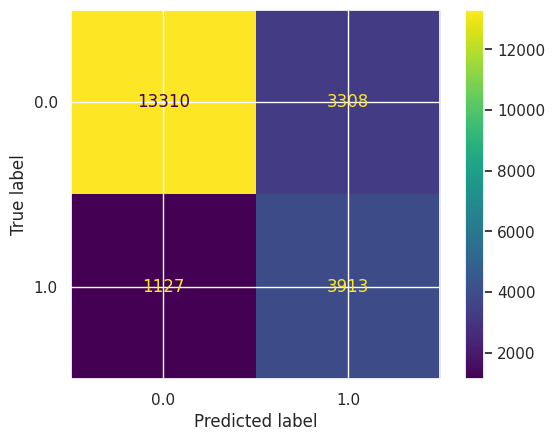

In [81]:
_ = ConfusionMatrixDisplay.from_estimator(logreg, X_train_scaled1, y_train_scaled1)



FP (False Positive): 3308(Casos incorrectamente clasificados como positivos, es decir, falsas alarmas de lluvia).

FN (False Negative): 1127(Casos incorrectamente clasificados como negativos, es decir, lluvia no detectada)

**CURVA ROC**

In [82]:
# Obtengo las probabilidades de predicción del modelo
y_probs = logreg.predict_proba(X_train_clasificacion)[:, 1]

#Calculo la ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_train_rain_tomorrow, y_probs)
roc_auc = auc(fpr, tpr)

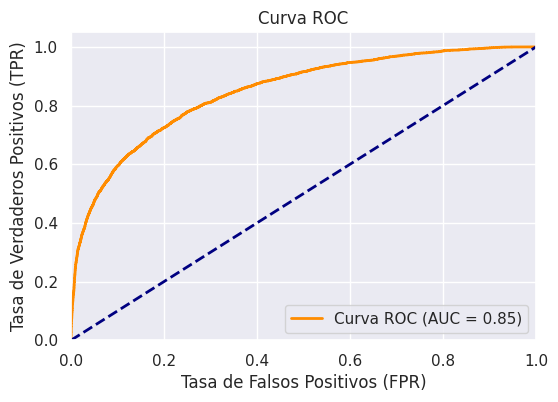

In [83]:
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

Por lo general, lo que buscamos es un clasificador que mantenga una alta tasa de verdaderos positivos y al mismo tiempo tenga una baja tasa de falsos positivos; este clasificador ideal tendería a pasar muy próximo a la esquina superior izquierda de la figura

**Indice de Youden** (o estadística J de Youden):
 se utiliza para seleccionar el corte de probabilidad pronosticado óptimo. Es la distancia vertical máxima entre la curva ROC y la línea diagonal, donde la idea es maximizar la diferencia entre la tasa de verdaderos positivos y la tasa de falsos positivos.

**Indice de Youden(J)** = Sensitivity - (1-Specificity) = Recall - (1 - Precision)

In [84]:
J_train = recall_train - (1 - precision_train)
J_train

0.3182805936389236

Calculando el indice de Youden, un punto de corte optimo seria 0.32.

AUC = 0.85, nos indica que tiene un buen desempeño del clasificador, ya que su valor maximo es 1(clasificacion perfecta)

### Modelo de test

In [85]:
# Realizar predicciones en el conjunto de testeo
y_pred = logreg.predict(X_test_scaled1)

In [86]:
accuracy_test = log_loss(y_test_scaled1, y_pred)
recall_test = recall_score(y_pred,y_test_scaled1)
precision_test = precision_score(y_pred,y_test_scaled1)
classification_report_test = classification_report(y_test_scaled1, y_pred)

# Imprimir métricas para el conjunto de entrenamiento
print("Métricas para el conjunto de entrenamiento:")
print('Logloss:%.2f' %(accuracy_test))
print("Reporte de clasificación de test:")
print(classification_report_test)

Métricas para el conjunto de entrenamiento:
Logloss:7.32
Reporte de clasificación de test:
              precision    recall  f1-score   support

         0.0       0.92      0.81      0.86      4159
         1.0       0.54      0.77      0.64      1255

    accuracy                           0.80      5414
   macro avg       0.73      0.79      0.75      5414
weighted avg       0.83      0.80      0.81      5414



Para la clase "True" ("lluvia_mañana_si):

La precisión es 0.54, lo que significa que el 54% de las veces que el modelo predijo "lluvia", estas predicciones fueron correctas.

El recall es del 0.77, lo que significa que el 77% de las veces, el modelo identificó la clase positiva.

La perdida logaritmica es 7.32 ,baja, es decir, la probabilidad predicha esta cerca de la etiquet real.

En el conjunto de test se mantiene un recall y una precision similar al de train.

El f1-score es 0.64 tambiien se mantiene igual al train.



### **Matriz de confusion**

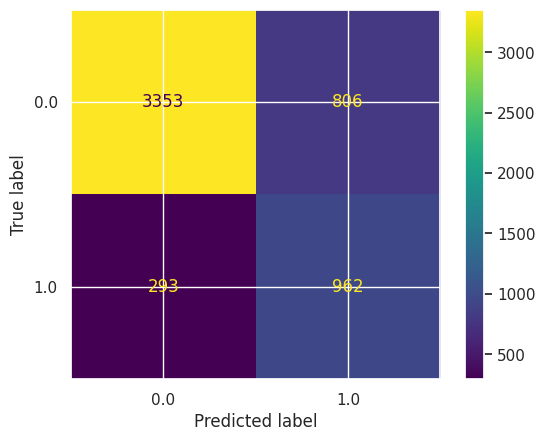

In [87]:
_ = ConfusionMatrixDisplay.from_estimator(logreg, X_test_scaled1, y_test_scaled1)

Falsos Positivos (FP): 806
Son los casos en los que el modelo predijo incorrectamente que llovería (clase "True") cuando en realidad no llovió.

Falsos Negativos (FN): 293
Son los casos en los que el modelo predijo incorrectamente que no llovería (clase "False") cuando en realidad llovió.

**CURVA ROC**

In [89]:
# Obtengo las probabilidades de predicción del modelo
y_probs_test = logreg.predict_proba(X_test_clasificacion)[:, 1]

# Calculo la ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test_rain_tomorrow, y_probs_test)
roc_auc = auc(fpr, tpr)

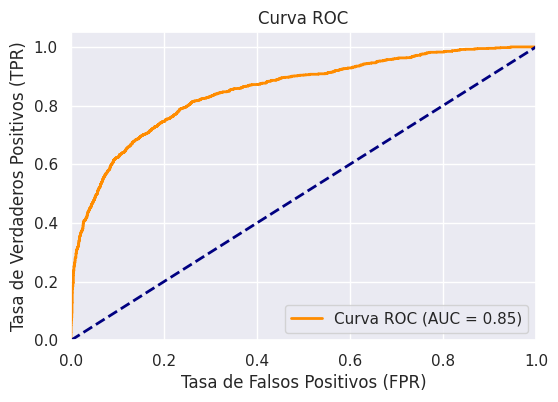

In [90]:
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [91]:
J_test = recall_test - (1- precision_test )
J_test

0.3106515116006562

Calculando el indice de Youden, el punto de corte optimo seria 0.31 en test.

Podemos ver en la grafica que 0.5 no es el mejor.

El AUC = 0.85, nos indica que hemos conseguido buen desempeño del clasificador par el conjunto de test.

Consideramos que hemos conseguido fitting bueno ya que los resultados en train y test son similares.

### MODELO BASE

### Regresion lineal

Vamos a predecir los milimetros de lluvia que caeran mañana, teniendo en cuenta la humedad a las 3pm,utilizando una regresion lineal simple.

In [92]:
df_train_codificado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21658 entries, 0 to 21657
Data columns (total 75 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   MinTemp                    21658 non-null  float64
 1   MaxTemp                    21658 non-null  float64
 2   Rainfall                   21658 non-null  float64
 3   Evaporation                21658 non-null  float64
 4   Sunshine                   21658 non-null  float64
 5   WindGustSpeed              21658 non-null  float64
 6   WindSpeed9am               21658 non-null  float64
 7   WindSpeed3pm               21658 non-null  float64
 8   Humidity9am                21658 non-null  float64
 9   Humidity3pm                21658 non-null  float64
 10  Pressure9am                21658 non-null  float64
 11  Pressure3pm                21658 non-null  float64
 12  Cloud9am                   21658 non-null  float64
 13  Cloud3pm                   21658 non-null  flo

In [93]:
df_train_codificado[["Humidity3pm", "RainfallTomorrow"]].head(5)

,Humidity3pm,RainfallTomorrow
0,43.000,0.000
1,40.000,0.000
2,22.000,0.000
3,28.875,0.175
4,13.000,0.000


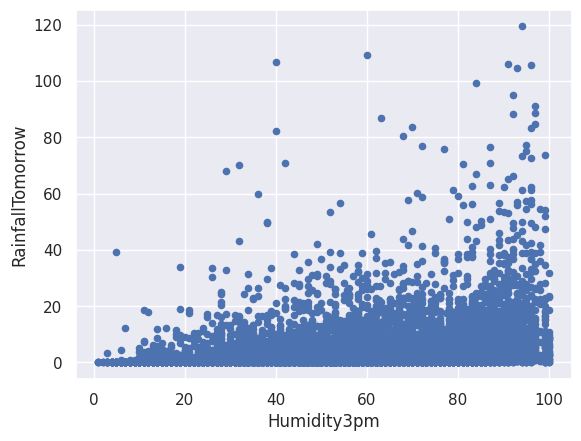

In [94]:
df_train_codificado.plot.scatter(x="Humidity3pm", y="RainfallTomorrow")
plt.show()

In [95]:
X_train_base = X_train_regresion["Humidity3pm"]
X_test_base = X_test_regresion["Humidity3pm"]

In [96]:
X_train_base_scaled = np.array( scaler.fit_transform(X_train_base.values.reshape(-1,1)))
X_test_base_scaled = np.array(scaler.fit_transform(X_test_base.values.reshape(-1,1)))

In [97]:
regresion = LinearRegression()

In [98]:
regresion.fit(X_train_base_scaled,y_train_scaled)

LinearRegression()

In [99]:
y_pred_base_regresion = regresion.predict(X_test_base_scaled)

In [100]:
metricas(y_test_scaled, y_pred_base_regresion)

R2:   0.11
MSE:  40.22
MAE:  2.98


In [101]:
regresion.intercept_

array([1.9551513])

In [102]:
regresion.coef_

array([[2.62561414]])

El modelo solo explica el 11% de la variabilidad de los datos.
El MSE mide el error cuadratico medio de los errores al cuadrado, es decir la diferencia entre el valor predicho y el esperado.

### Clasificacion

In [ ]:
# Crear el modelo de Regresión Logística
model_base = LogisticRegression(l1_ratio = 0, random_state = 42)

# Entrenar el modelo con los datos de entrenamiento
model_base.fit(X_train_scaled1, y_train_scaled1)

# Realizar predicciones en el conjunto de prueba
y_pred_base = model_base.predict(X_test_scaled1)

# Calcular métricas
accuracy_logreg_base = accuracy_score(y_test_scaled1, y_pred_base) # compara el valor real y el predicho

classification_report_logreg_base = classification_report(y_test_scaled1, y_pred_base, zero_division=1)

# Imprimir métricas
print("Métricas para logreg:")
print(f'Precisión: {accuracy_logreg_base}')

print("Reporte de clasificación:")
print(classification_report_logreg_base)



Métricas para logreg:
Precisión: 0.8457702253417066
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90      4159
         1.0       0.73      0.54      0.62      1255

    accuracy                           0.85      5414
   macro avg       0.80      0.74      0.76      5414
weighted avg       0.84      0.85      0.84      5414



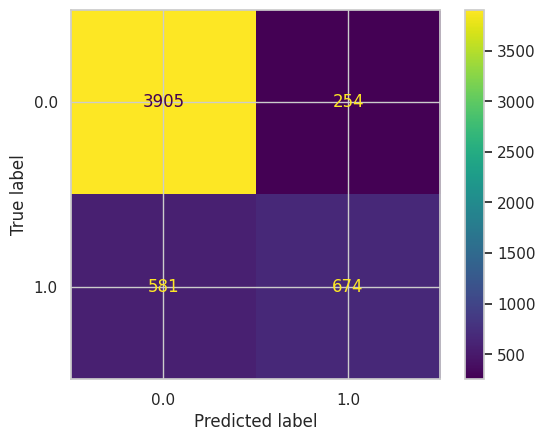

In [ ]:
_ = ConfusionMatrixDisplay.from_estimator(model_base, X_test_scaled1, y_test_scaled1)

EXPLICABILIDAD DEL MODELO de REGRESION(SHAP)

In [ ]:
feature_names= X_train_regresion.columns.values
feature_names

array(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Cloud3pm', 'Temp9am', 'Temp3pm', 'WindGustDir_SW',
       'WindDir9am_SW', 'WindDir3pm_SW', 'WindGustDir_S', 'WindDir9am_S',
       'WindDir3pm_S', 'WindGustDir_SSW', 'WindDir9am_SSW',
       'WindDir3pm_SSW', 'WindGustDir_W', 'WindDir9am_W', 'WindDir3pm_W',
       'WindGustDir_SSE', 'WindDir9am_SSE', 'WindDir3pm_SSE',
       'WindGustDir_E', 'WindDir9am_E', 'WindDir3pm_E', 'WindGustDir_SE',
       'WindDir9am_SE', 'WindDir3pm_SE', 'WindGustDir_NE',
       'WindDir9am_NE', 'WindDir3pm_NE', 'WindGustDir_NNE',
       'WindDir9am_NNE', 'WindDir3pm_NNE', 'WindGustDir_WSW',
       'WindDir9am_WSW', 'WindDir3pm_WSW', 'WindGustDir_WNW',
       'WindDir9am_WNW', 'WindDir3pm_WNW', 'WindGustDir_NW',
       'WindDir9am_NW', 'WindDir3pm_NW', 'WindGustDir_N', 'WindDir9am_N',
       'WindDir3

In [ ]:
# Crea un objeto explainer SHAP
explainer = shap.LinearExplainer(logreg, X_train_scaled, feature_names=feature_names)

In [ ]:
# Calcula los valores SHAP para un conjunto de ejemplos de prueba
shap_values = explainer(X_test_scaled)

In [ ]:
shap_values.shape

(5414, 74)

In [ ]:
explainer.expected_value

-3.985866735351044

INTERPRETABILIDAD LOCAL

In [ ]:
index=0

In [ ]:
logreg.predict_proba(X_test_scaled)[index]

array([0.96225214, 0.03774786])

In [ ]:
logreg.predict(X_test_scaled)[index]

0.0

In [ ]:
shap_values[index]

.values =
array([ 2.38123262e-02, -5.57420440e-02, -4.28146402e-02,  5.22162557e-02,
        1.42671491e-01,  3.66181330e-01,  1.55208123e-01,  1.25484421e-02,
       -1.42531370e-03,  1.28492446e-01, -5.88124690e-02,  2.86102032e-01,
        1.54091571e-02,  1.85059195e-01, -1.97031761e-01,  1.44567008e-02,
       -2.40760152e-01, -1.86584476e-03, -4.63836902e-03,  7.22163386e-03,
        1.70675972e-02, -2.86343486e-01, -9.99124058e-03,  7.67452407e-03,
        3.23568219e-02, -1.32417910e-02,  7.32954873e-03,  3.30787948e-04,
        2.16628420e-03,  6.62987131e-03,  1.17691423e-02,  1.89150288e-03,
        8.32101094e-03,  6.53554344e-03, -4.61224876e-03,  3.07031935e-02,
        8.03931047e-03, -1.41929381e-02,  8.31789483e-03,  1.22541299e-03,
       -2.45049461e-03,  1.65955424e-02, -5.18390215e-03, -8.80827474e-03,
        1.03312968e-02,  1.35012974e-02, -9.36574989e-03, -4.85685575e-03,
        1.87801900e-04,  1.39309149e-03,  2.54595008e-02,  9.35253465e-04,
       -1.70925

In [ ]:
explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=feature_names)

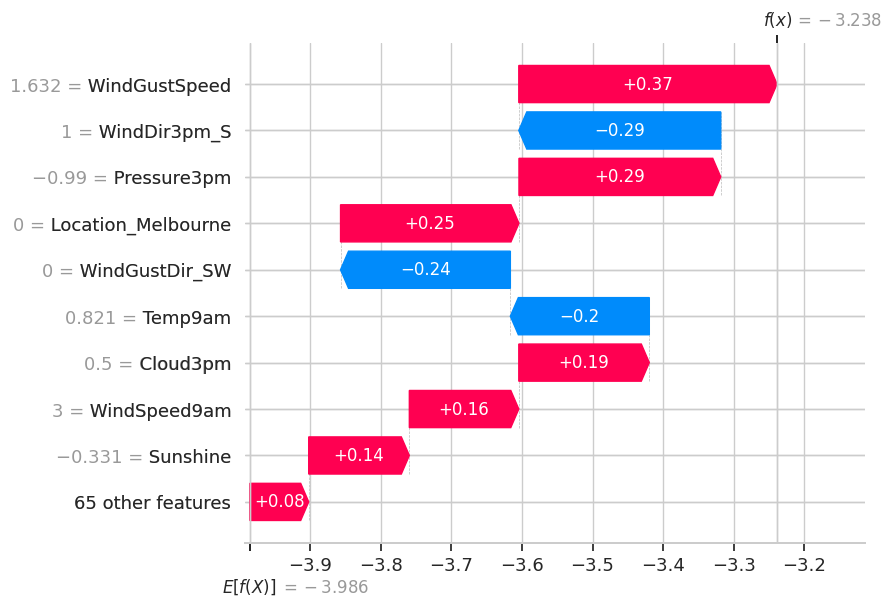

In [ ]:
shap.plots.waterfall(explanation, max_display=10)

El valor base es = -3.986.
La prediccion de la variable RainfallTomorrow de una instancia se calcula f(x) = -3.986 + sum(SHAP values)

En la grafica observamos flechas sobre las cuales, se encuentran las cantidades y marcan la direccion en la que cada  variable impacta en la prediccion de la target.

Observamos que entre las variables que mayor contribuyen estan:

WindDir3pm_S (-0.29)

WindGustDir_SW (-0.24)

Temp9am (-0.20)

 WindGustSpeed(+ 0.37)

 Pressure3pm (+ 0.29)

 Location_Melbourne (+ 0.25)

 Cloud3pm (+ 0.19)

 WindSpeed9am (+ 0.16)

 Sunshine (+ 0.14)

El resto de las variables aportan el 8% restante positivamente.

En la instancia considerada f(x) = -3.238

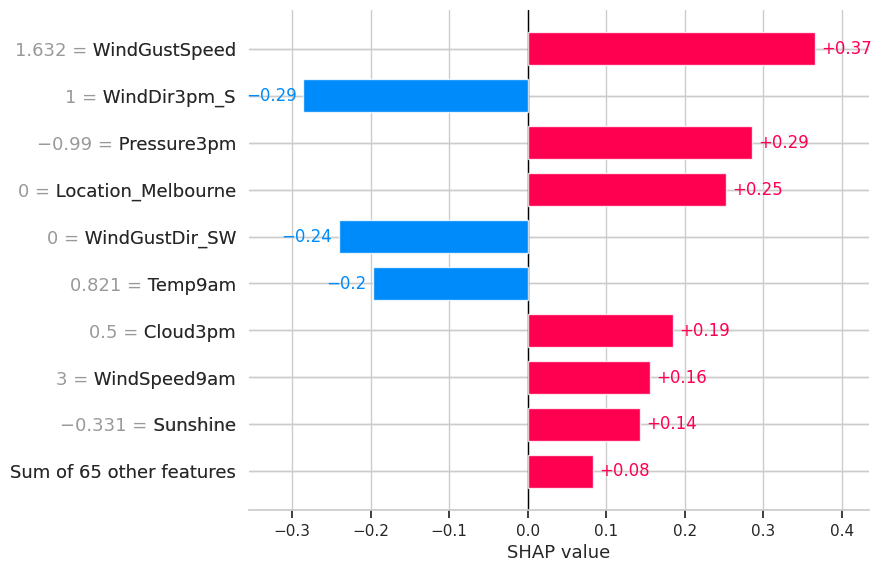

In [ ]:
shap.plots.bar(explanation)

En esta grafica, se observa claramente que las variables WindDir3pm_S, WindGustDir_SW y Temp9am, imprimen una fuerza negativa sobre el valor base de 0.55 y las demas 1.48 positivamente.
Es decir la cantidad de lluvia disminuye ante valores altos de estas variables y aumenta si estos son bajos.   

INTEPRETABILIDAD GLOBAL REGRESION

In [ ]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=feature_names, data=X_test_scaled)

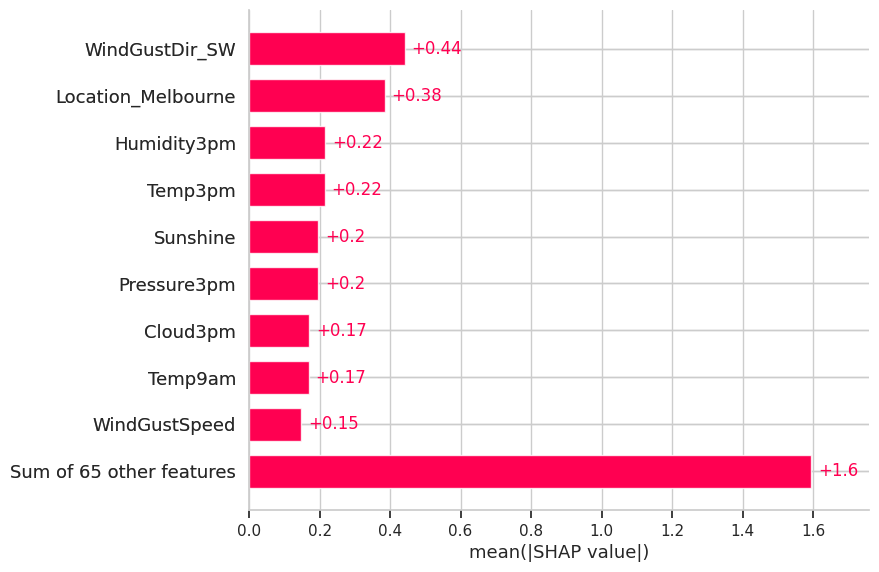

In [ ]:
shap.plots.bar(explanation)

En este grafico de barras, estan representadas las medias absolutas de los SHAP values, donde de mayor a menor, esa magnitud en valor absoluto refleja el impacto en la predicion para todas las instancias.

WindGustDir_SW con 0.44 y Location_Melbourne con 0.38 son las mas preponderantes

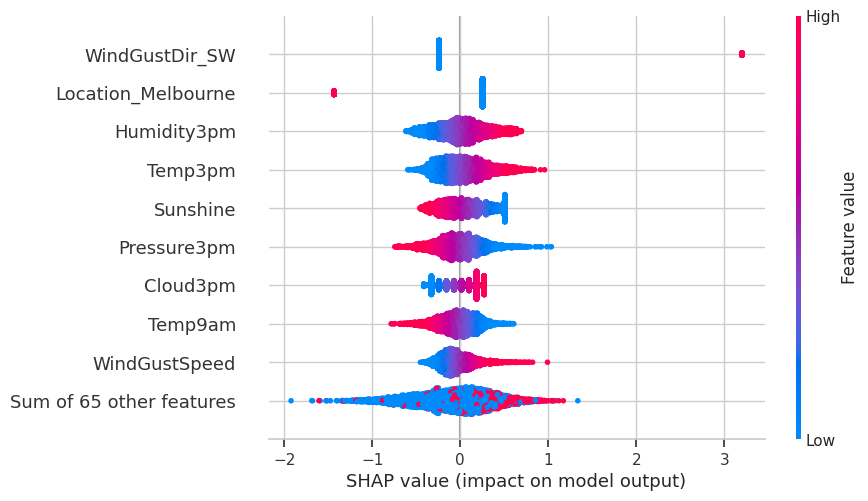

In [ ]:
shap.plots.beeswarm(explanation)

EXPLICABILIDAD DEL MODELO DE CLASIFICACION (SHAP)

In [ ]:
feature_names= X_train_clasificacion.columns.values
feature_names

array(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Cloud3pm', 'Temp9am', 'Temp3pm', 'WindGustDir_SW',
       'WindDir9am_SW', 'WindDir3pm_SW', 'WindGustDir_S', 'WindDir9am_S',
       'WindDir3pm_S', 'WindGustDir_SSW', 'WindDir9am_SSW',
       'WindDir3pm_SSW', 'WindGustDir_W', 'WindDir9am_W', 'WindDir3pm_W',
       'WindGustDir_SSE', 'WindDir9am_SSE', 'WindDir3pm_SSE',
       'WindGustDir_E', 'WindDir9am_E', 'WindDir3pm_E', 'WindGustDir_SE',
       'WindDir9am_SE', 'WindDir3pm_SE', 'WindGustDir_NE',
       'WindDir9am_NE', 'WindDir3pm_NE', 'WindGustDir_NNE',
       'WindDir9am_NNE', 'WindDir3pm_NNE', 'WindGustDir_WSW',
       'WindDir9am_WSW', 'WindDir3pm_WSW', 'WindGustDir_WNW',
       'WindDir9am_WNW', 'WindDir3pm_WNW', 'WindGustDir_NW',
       'WindDir9am_NW', 'WindDir3pm_NW', 'WindGustDir_N', 'WindDir9am_N',
       'WindDir3

In [ ]:
# Crea un objeto explainer SHAP
explainer = shap.LinearExplainer(logreg, X_train_scaled1, feature_names=feature_names)

In [ ]:
# Calcula los valores SHAP para un conjunto de ejemplos de prueba
shap_values = explainer(X_test_scaled1)

In [ ]:
shap_values.shape

(5414, 73)

In [ ]:
explainer.expected_value

-0.5450468534530964

INTERPRETABILIDAD LOCAL DE CLASIFICACION

In [ ]:
index=0

In [ ]:
logreg.predict_proba(X_test_scaled1)[index]

array([0.08268942, 0.91731058])

In [ ]:
logreg.predict(X_test_scaled1)[index]

1.0

In [ ]:
shap_values[index]

.values =
array([-5.06836186e-02, -8.97483357e-02,  9.12763016e-02,  9.99548239e-03,
        2.82280994e-01,  1.42629530e+00, -2.29623075e-02,  2.40128011e-02,
       -7.92514124e-03,  4.92885386e-01, -1.08260174e+00,  1.61139748e+00,
        2.23153076e-02,  3.44722463e-01,  3.94813295e-02,  1.82758800e-02,
       -2.51534577e-04,  1.00966955e-03,  6.66522916e-03,  9.72514351e-03,
        3.94231001e-02, -1.28820496e-01,  1.38400133e-02,  1.48559396e-02,
        9.71303709e-03,  2.76554853e-02, -3.81096392e-03,  1.01967973e-02,
        3.02503746e-03,  8.39603828e-03,  6.29751717e-03, -6.91768827e-03,
       -5.44698027e-03,  1.88494856e-02,  9.96703379e-03,  3.38836385e-03,
        1.09848259e-03,  1.96014666e-02, -1.16938268e-02,  1.39445582e-02,
        1.34867740e-02, -2.13557122e-02, -1.54485383e-03,  2.02335536e-02,
       -6.77857601e-03,  2.07210822e-02,  7.10723011e-04,  1.99525875e-03,
        6.02957968e-03,  1.09751420e-02,  1.54687447e-02,  8.23829426e-03,
       -3.98635

In [ ]:
explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=feature_names)

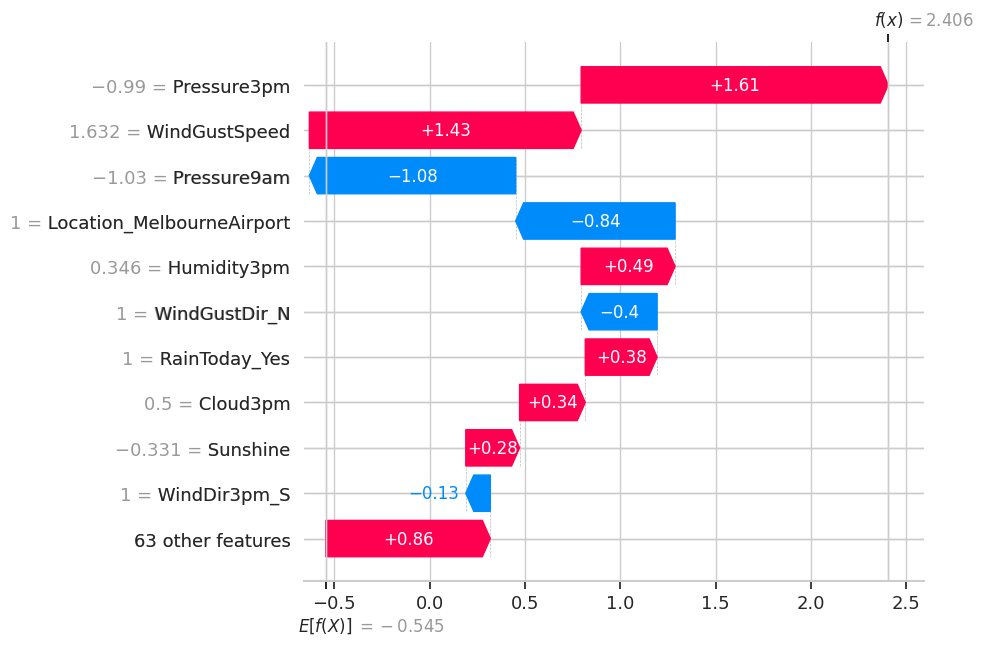

In [ ]:
shap.plots.waterfall(explanation, max_display=11)

El valor base es = -0.545. La prediccion de la variable RainTomorrow de una instancia se calcula f(x) = -0.545 + sum(SHSP values)

En la grafica observamos en rojo las variables que contribuyen positivamente al modelo de prediccion y en azul las que lo hacen negativamente. Sobre la misma, se refleja las cantidades de esa contribucion, las flechas tambien marcan la direccion en que impacta cada variable en la prediccion.

Observamos que entre las variables que mayor contribuyen estan:

Pressure3pm (+1.61)

WindGustSpeed(+1.43)

Humidity3pm(+0.49)

RainToday_Yes (+0.38)

Cloud3pm (+ 0.34)

Sunshine (+ 0.28)

Pressure9am (-1.08)

Location_MelbourneAirport (- 0.84)

WindGustDir_N(- 0.4)

WindDir3pm_S(+ 0.37)

El resto de las variables aportan el 8.6% restante positivamente.

En la instancia considerada f(x) = 2.406

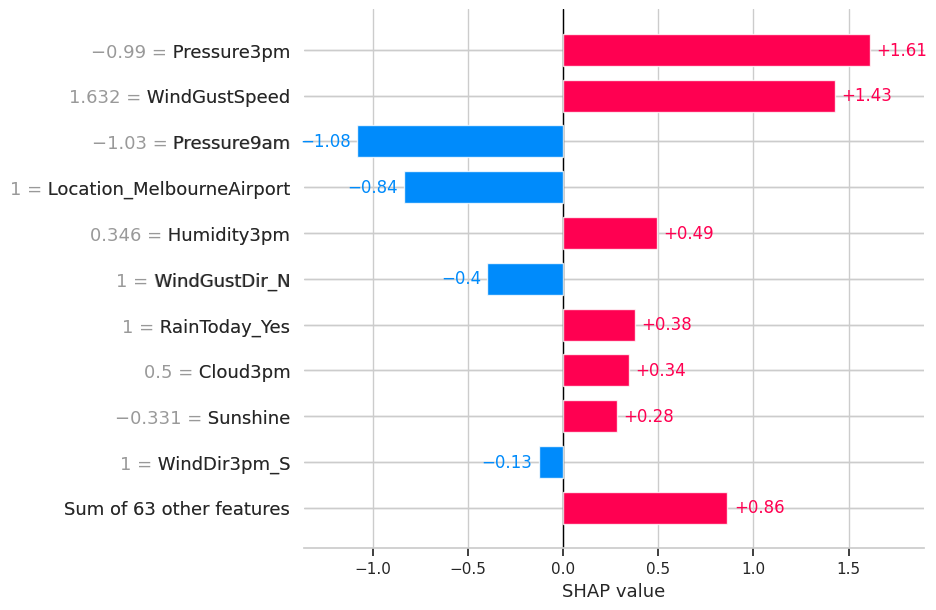

In [ ]:
shap.plots.bar(explanation, max_display=11)

En esta grafica, se observa claramente que las variables  **WindGustSpeed** y **Pressure3pm**, son las que mas influyen en positivamente en la prediccion, es decir, la cantidad de "lluvia_caida_mañana" aumente con valores altos de estas variables.

 Por el contrario, las variables **Pressure9am** y **Location_MelbourneAirport** son las que mas contribuyen negativamente al caida e lluvia.

INTERPRETABILIDAD GLOBAL CLASIFICACION

In [ ]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=feature_names, data=X_test_clasificacion)

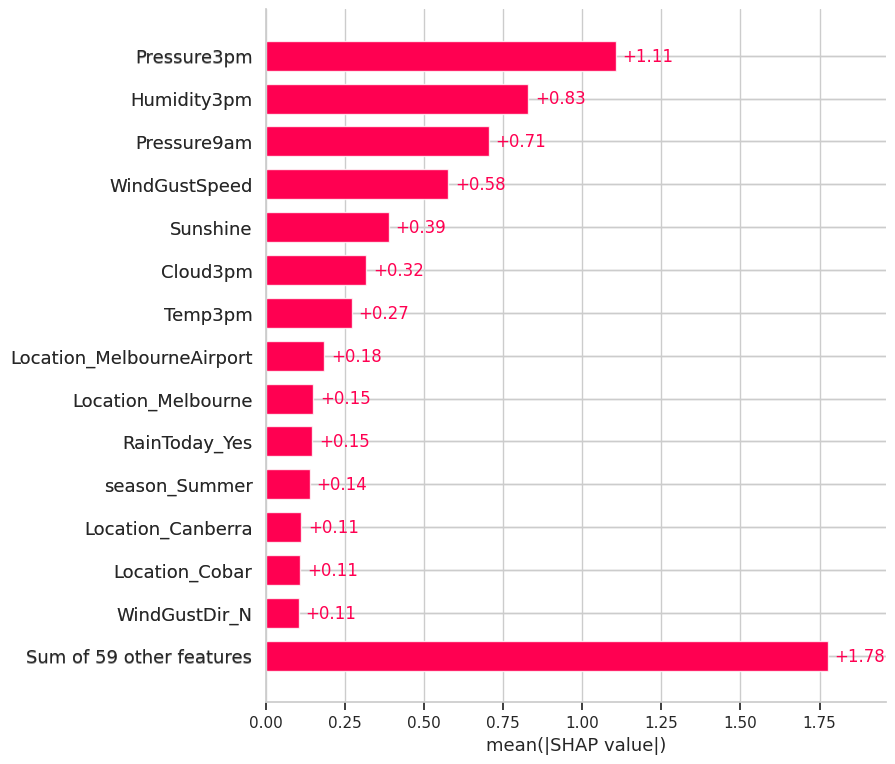

In [ ]:
shap.plots.bar(explanation, max_display=15)

En este grafico de barras, estan representadas las medias absolutas de los SHAP values, donde de mayor a menor, esa magnitud en valor absoluto refleja el impacto en la predicion para todas las instancias.



1.   **Pressure3pm (1.11)**
2.   **Humidity3pm(0.83)**
3.   **Pressure9pm (0.71)**
4.   **WndGustSpeed(0.58)**





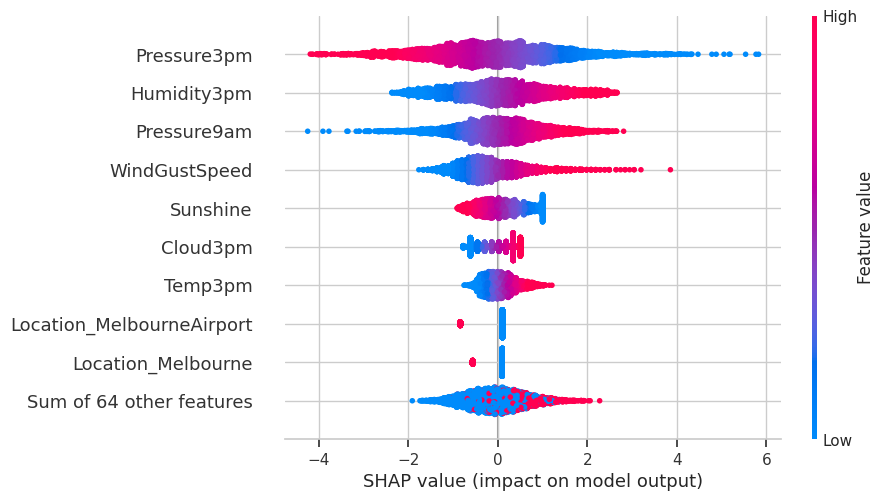

In [ ]:
shap.plots.beeswarm(explanation)

**Nota:** no implementamos validacion cruzada ya que vamos a utilizar GridSearchCV y RandomSearchCV

### Optimizacion parametros modelo de Regresion

GRID SEARCH con validacion cruzada

In [242]:
params = {
       'fit_intercept': [True, False],
       'n_jobs': [None, 1],
       'positive': [True, False]}


In [243]:
# función para entrenar y evaluar un modelo con hiperparámetros dados
def train_evaluate_model(params, X_train, y_train, X_test, y_test):
    model = LinearRegression(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

In [244]:
grid_search = GridSearchCV(LinearRegression(), params, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train_scaled)
best_grid_params = grid_search.best_params_
best_grid_model = LinearRegression(**best_grid_params)
best_grid_model.fit(X_train_scaled, y_train_scaled)
grid_search_mse = mean_squared_error(y_test_scaled, best_grid_model.predict(X_test_scaled))

In [245]:
best_grid_params

{'fit_intercept': False, 'n_jobs': None, 'positive': False}

RANDOM SEARCH con validacion cruzada

In [246]:
random_search = RandomizedSearchCV(LinearRegression(),params, scoring='neg_mean_squared_error')
random_search.fit(X_train_scaled, y_train_scaled)
best_random_params = random_search.best_params_
best_random_model = LinearRegression(**best_random_params)
best_random_model.fit(X_train_scaled, y_train_scaled)
random_search_mse = mean_squared_error(y_test_scaled, best_random_model.predict(X_test_scaled))

In [247]:
best_random_params

{'positive': False, 'n_jobs': None, 'fit_intercept': False}

In [248]:
print("Grid Search MSE:", grid_search_mse)
print("Random Search MSE:", random_search_mse)

Grid Search MSE: 28.110049789407213
Random Search MSE: 28.110049789407213


### Optimizacion parametros modelo de Clasificacion

GRID SEARCH con validacion cruzada

In [134]:
### Para cada hiperparámetro se chequean las métricas de Precisión y Recall.
scores = ["precision", "recall"]

In [167]:
def print_dataframe(filtered_cv_results):
    ### Un print bonito de los resultados de cross validation
    for mean_precision, std_precision, mean_recall, std_recall, params in zip(
        filtered_cv_results["mean_test_precision"],
        filtered_cv_results["std_test_precision"],
        filtered_cv_results["mean_test_recall"],
        filtered_cv_results["std_test_recall"],
        filtered_cv_results["params"],
    ):
        print(
            f"precision: {mean_precision:0.3f} (±{std_precision:0.03f}),"
            f" recall: {mean_recall:0.3f} (±{std_recall:0.03f}),"
            f" for {params}"
        )
    print()

def refit_strategy(cv_results):
    precision_threshold = 0.7

    cv_results_ = pd.DataFrame(cv_results)
    print("All grid-search results:")
    print_dataframe(cv_results_)

    # Filter-out all results below the threshold
    high_precision_cv_results = cv_results_[
        cv_results_["mean_test_precision"] > precision_threshold
    ]

    print(f"Models with a precision higher than {precision_threshold}:")
    print_dataframe(high_precision_cv_results)

    high_precision_cv_results = high_precision_cv_results[
        [
            "mean_score_time",
            "mean_test_recall",
            "std_test_recall",
            "mean_test_precision",
            "std_test_precision",
            "rank_test_recall",
            "rank_test_precision",
            "params",
        ]
    ]

    # Select the most performant models in terms of recall
    # (within 1 sigma from the best)
    best_recall_std = high_precision_cv_results["mean_test_recall"].std()
    best_recall = high_precision_cv_results["mean_test_recall"].max()
    best_recall_threshold = best_recall - best_recall_std

    high_recall_cv_results = high_precision_cv_results[
        high_precision_cv_results["mean_test_recall"] > best_recall_threshold
    ]
    print(
        "Out of the previously selected high precision models, we keep all the\n"
        "the models within one standard deviation of the highest recall model:"
    )
    print_dataframe(high_recall_cv_results)

    # From the best candidates, select the fastest model to predict
    fastest_top_recall_high_precision_index = high_recall_cv_results[
        "mean_score_time"
    ].idxmin()

    print(
        "\nThe selected final model is the fastest to predict out of the previously\n"
        "selected subset of best models based on precision and recall.\n"
        "Its scoring time is:\n\n"
        f"{high_recall_cv_results.loc[fastest_top_recall_high_precision_index]}"
    )

    return fastest_top_recall_high_precision_index

In [170]:
tuned_parameters = [
    {"class_weight": [None, 'balanced'], "C": [0.1, 1, 10,100], \
     "solver": ['newton-cg', 'lbfgs'], \
     "max_iter": [200, 500]}
]

grid_search = GridSearchCV(
    LogisticRegression(), tuned_parameters, scoring=scores, refit=refit_strategy
)
grid_search.fit(X_train_scaled1, y_train_scaled1)

All grid-search results:
precision: 0.721 (±0.025), recall: 0.514 (±0.046), for {'C': 0.1, 'class_weight': None, 'max_iter': 200, 'solver': 'newton-cg'}
precision: 0.721 (±0.025), recall: 0.514 (±0.046), for {'C': 0.1, 'class_weight': None, 'max_iter': 200, 'solver': 'lbfgs'}
precision: 0.721 (±0.025), recall: 0.514 (±0.046), for {'C': 0.1, 'class_weight': None, 'max_iter': 500, 'solver': 'newton-cg'}
precision: 0.721 (±0.025), recall: 0.514 (±0.046), for {'C': 0.1, 'class_weight': None, 'max_iter': 500, 'solver': 'lbfgs'}
precision: 0.535 (±0.023), recall: 0.768 (±0.032), for {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 200, 'solver': 'newton-cg'}
precision: 0.535 (±0.023), recall: 0.768 (±0.032), for {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 200, 'solver': 'lbfgs'}
precision: 0.535 (±0.023), recall: 0.768 (±0.032), for {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 500, 'solver': 'newton-cg'}
precision: 0.535 (±0.023), recall: 0.768 (±0.032), for {'C': 0.1, 'class_

GridSearchCV(estimator=LogisticRegression(),
             param_grid=[{'C': [0.1, 1, 10, 100],
                          'class_weight': [None, 'balanced'],
                          'max_iter': [200, 500],
                          'solver': ['newton-cg', 'lbfgs']}],
             refit=<function refit_strategy at 0x7d6dc752dab0>,
             scoring=['precision', 'recall'])

In [171]:
grid_search.best_params_

{'C': 1, 'class_weight': None, 'max_iter': 200, 'solver': 'lbfgs'}

Modelo de clasificacion optimizado con GridSearchCV

In [172]:
logreg_optimo = LogisticRegression(random_state=42, C= 1, class_weight = None, \
                                   max_iter= 200, solver= 'lbfgs')

In [173]:
logreg_optimo.fit(X_train_scaled1, y_train_scaled1)

LogisticRegression(C=1, max_iter=200, random_state=42)

In [174]:
y_pred_optimo = logreg_optimo.predict(X_test_scaled1)

In [175]:
classification_report_optimo = classification_report(y_test_scaled1, y_pred_optimo)
print(classification_report_optimo)

              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90      4159
         1.0       0.73      0.54      0.62      1255

    accuracy                           0.85      5414
   macro avg       0.80      0.74      0.76      5414
weighted avg       0.84      0.85      0.84      5414



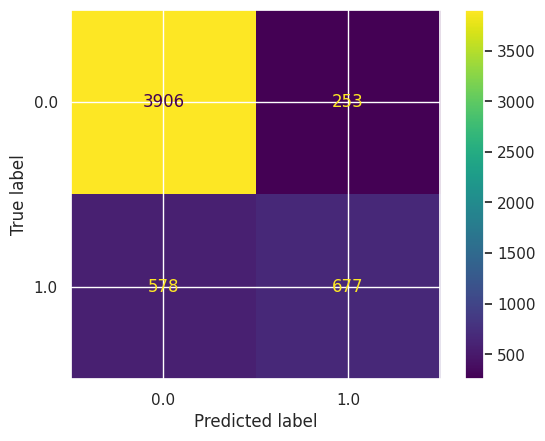

In [176]:
_ = ConfusionMatrixDisplay.from_estimator(logreg_optimo, X_test_scaled1, y_test_scaled1)

RANDOM SEARCH con validacion cruzada

In [250]:
tuned_parameters = [
    {"class_weight": [None, 'balanced'], "C": [0.1, 1, 10,100], \
     "solver": ['newton-cg', 'lbfgs'], \
     "max_iter": [200, 500]}
]

random_search = RandomizedSearchCV(
    LogisticRegression(), tuned_parameters, scoring=scores, refit=refit_strategy
)
random_search.fit(X_train_scaled1, y_train_scaled1)

All grid-search results:
precision: 0.537 (±0.024), recall: 0.769 (±0.033), for {'solver': 'lbfgs', 'max_iter': 200, 'class_weight': 'balanced', 'C': 10}
precision: 0.721 (±0.025), recall: 0.514 (±0.046), for {'solver': 'lbfgs', 'max_iter': 500, 'class_weight': None, 'C': 0.1}
precision: 0.537 (±0.024), recall: 0.769 (±0.033), for {'solver': 'newton-cg', 'max_iter': 200, 'class_weight': 'balanced', 'C': 10}
precision: 0.535 (±0.023), recall: 0.768 (±0.032), for {'solver': 'newton-cg', 'max_iter': 200, 'class_weight': 'balanced', 'C': 0.1}
precision: 0.536 (±0.024), recall: 0.769 (±0.033), for {'solver': 'lbfgs', 'max_iter': 200, 'class_weight': 'balanced', 'C': 1}
precision: 0.717 (±0.024), recall: 0.522 (±0.046), for {'solver': 'newton-cg', 'max_iter': 200, 'class_weight': None, 'C': 10}
precision: 0.721 (±0.025), recall: 0.514 (±0.046), for {'solver': 'lbfgs', 'max_iter': 200, 'class_weight': None, 'C': 0.1}
precision: 0.717 (±0.025), recall: 0.521 (±0.046), for {'solver': 'lbfgs', '

RandomizedSearchCV(estimator=LogisticRegression(),
                   param_distributions=[{'C': [0.1, 1, 10, 100],
                                         'class_weight': [None, 'balanced'],
                                         'max_iter': [200, 500],
                                         'solver': ['newton-cg', 'lbfgs']}],
                   refit=<function refit_strategy at 0x7d6dc752dab0>,
                   scoring=['precision', 'recall'])

In [251]:
random_search.best_params_

{'solver': 'newton-cg', 'max_iter': 200, 'class_weight': None, 'C': 10}

Modelo de clasificacion optimizado con RandomizedSearchCV

In [252]:
logreg_optimo1 = LogisticRegression(random_state=42, C= 10, class_weight = None, \
                                   max_iter= 200, solver= 'newton-cg')

In [253]:
logreg_optimo1.fit(X_train_scaled1, y_train_scaled1)

LogisticRegression(C=10, max_iter=200, random_state=42, solver='newton-cg')

In [254]:
y_pred_optimo1 = logreg_optimo1.predict(X_test_scaled1)

In [256]:
classification_report_optimo1 = classification_report(y_test_scaled1, y_pred_optimo1)
print(classification_report_optimo1)

              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90      4159
         1.0       0.73      0.54      0.62      1255

    accuracy                           0.85      5414
   macro avg       0.80      0.74      0.76      5414
weighted avg       0.84      0.85      0.84      5414



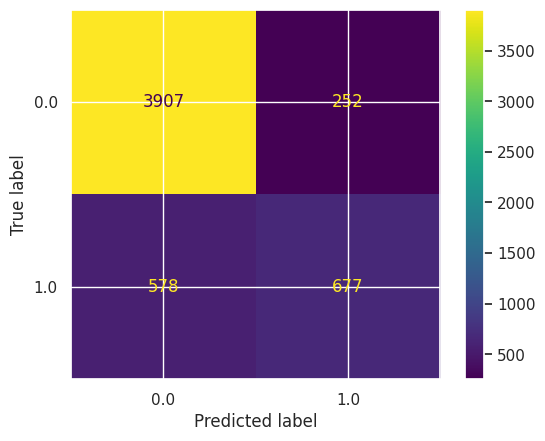

In [257]:
_ = ConfusionMatrixDisplay.from_estimator(logreg_optimo1, X_test_scaled1, y_test_scaled1)